**Thermal IWO ML-assisted Modeling (June 2024)**

0.05
0.08368200836820085
3801
181
7
3
[8.542230000000006e-08, 1.6659900000000002e-07, 1.5764499999999995e-06, 4.372939999999999e-06, 8.269920000000007e-06, 1.1931100000000005e-05, 1.5508399999999985e-05]
[25 55 85]

1.59554e-05
[0, 1, 2]
[-4.806755708764493, -4.653688109402998, -4.557873140560599]
[[1.         0.89977637]
 [0.89977637 1.        ]]
[[1.         0.99933916]
 [0.99933916 1.        ]]
[[1.         0.99129535]
 [0.99129535 1.        ]]


<ipython-input-80-c986fe7aa3a4>:174: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.fc1.weight)
<ipython-input-80-c986fe7aa3a4>:175: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.fc2.weight)
<ipython-input-80-c986fe7aa3a4>:176: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.fc3.weight)


Loss (epoch:   10): 0.06715515
Loss (epoch:   20): 0.02095491
Loss (epoch:   30): 0.01592611
Loss (epoch:   40): 0.01023740
Loss (epoch:   50): 0.00555559
Loss (epoch:   60): 0.00321880
Loss (epoch:   70): 0.00222364
Loss (epoch:   80): 0.00162831
Loss (epoch:   90): 0.00114763
Loss (epoch:  100): 0.00085166
Loss (epoch:  110): 0.00071759
Loss (epoch:  120): 0.00065202
Loss (epoch:  130): 0.00060775
Loss (epoch:  140): 0.00056867
Loss (epoch:  150): 0.00052876
Loss (epoch:  160): 0.00048863
Loss (epoch:  170): 0.00045058
Loss (epoch:  180): 0.00041678
Loss (epoch:  190): 0.00038745
Loss (epoch:  200): 0.00036150
Loss (epoch:  210): 0.00033780
Loss (epoch:  220): 0.00031535
Loss (epoch:  230): 0.00029329
Loss (epoch:  240): 0.00027094
Loss (epoch:  250): 0.00024762
Loss (epoch:  260): 0.00022268
Loss (epoch:  270): 0.00019593
Loss (epoch:  280): 0.00016914
Loss (epoch:  290): 0.00014814
Loss (epoch:  300): 0.00013424
Loss (epoch:  310): 0.00012740
Loss (epoch:  320): 0.00012387
Loss (ep

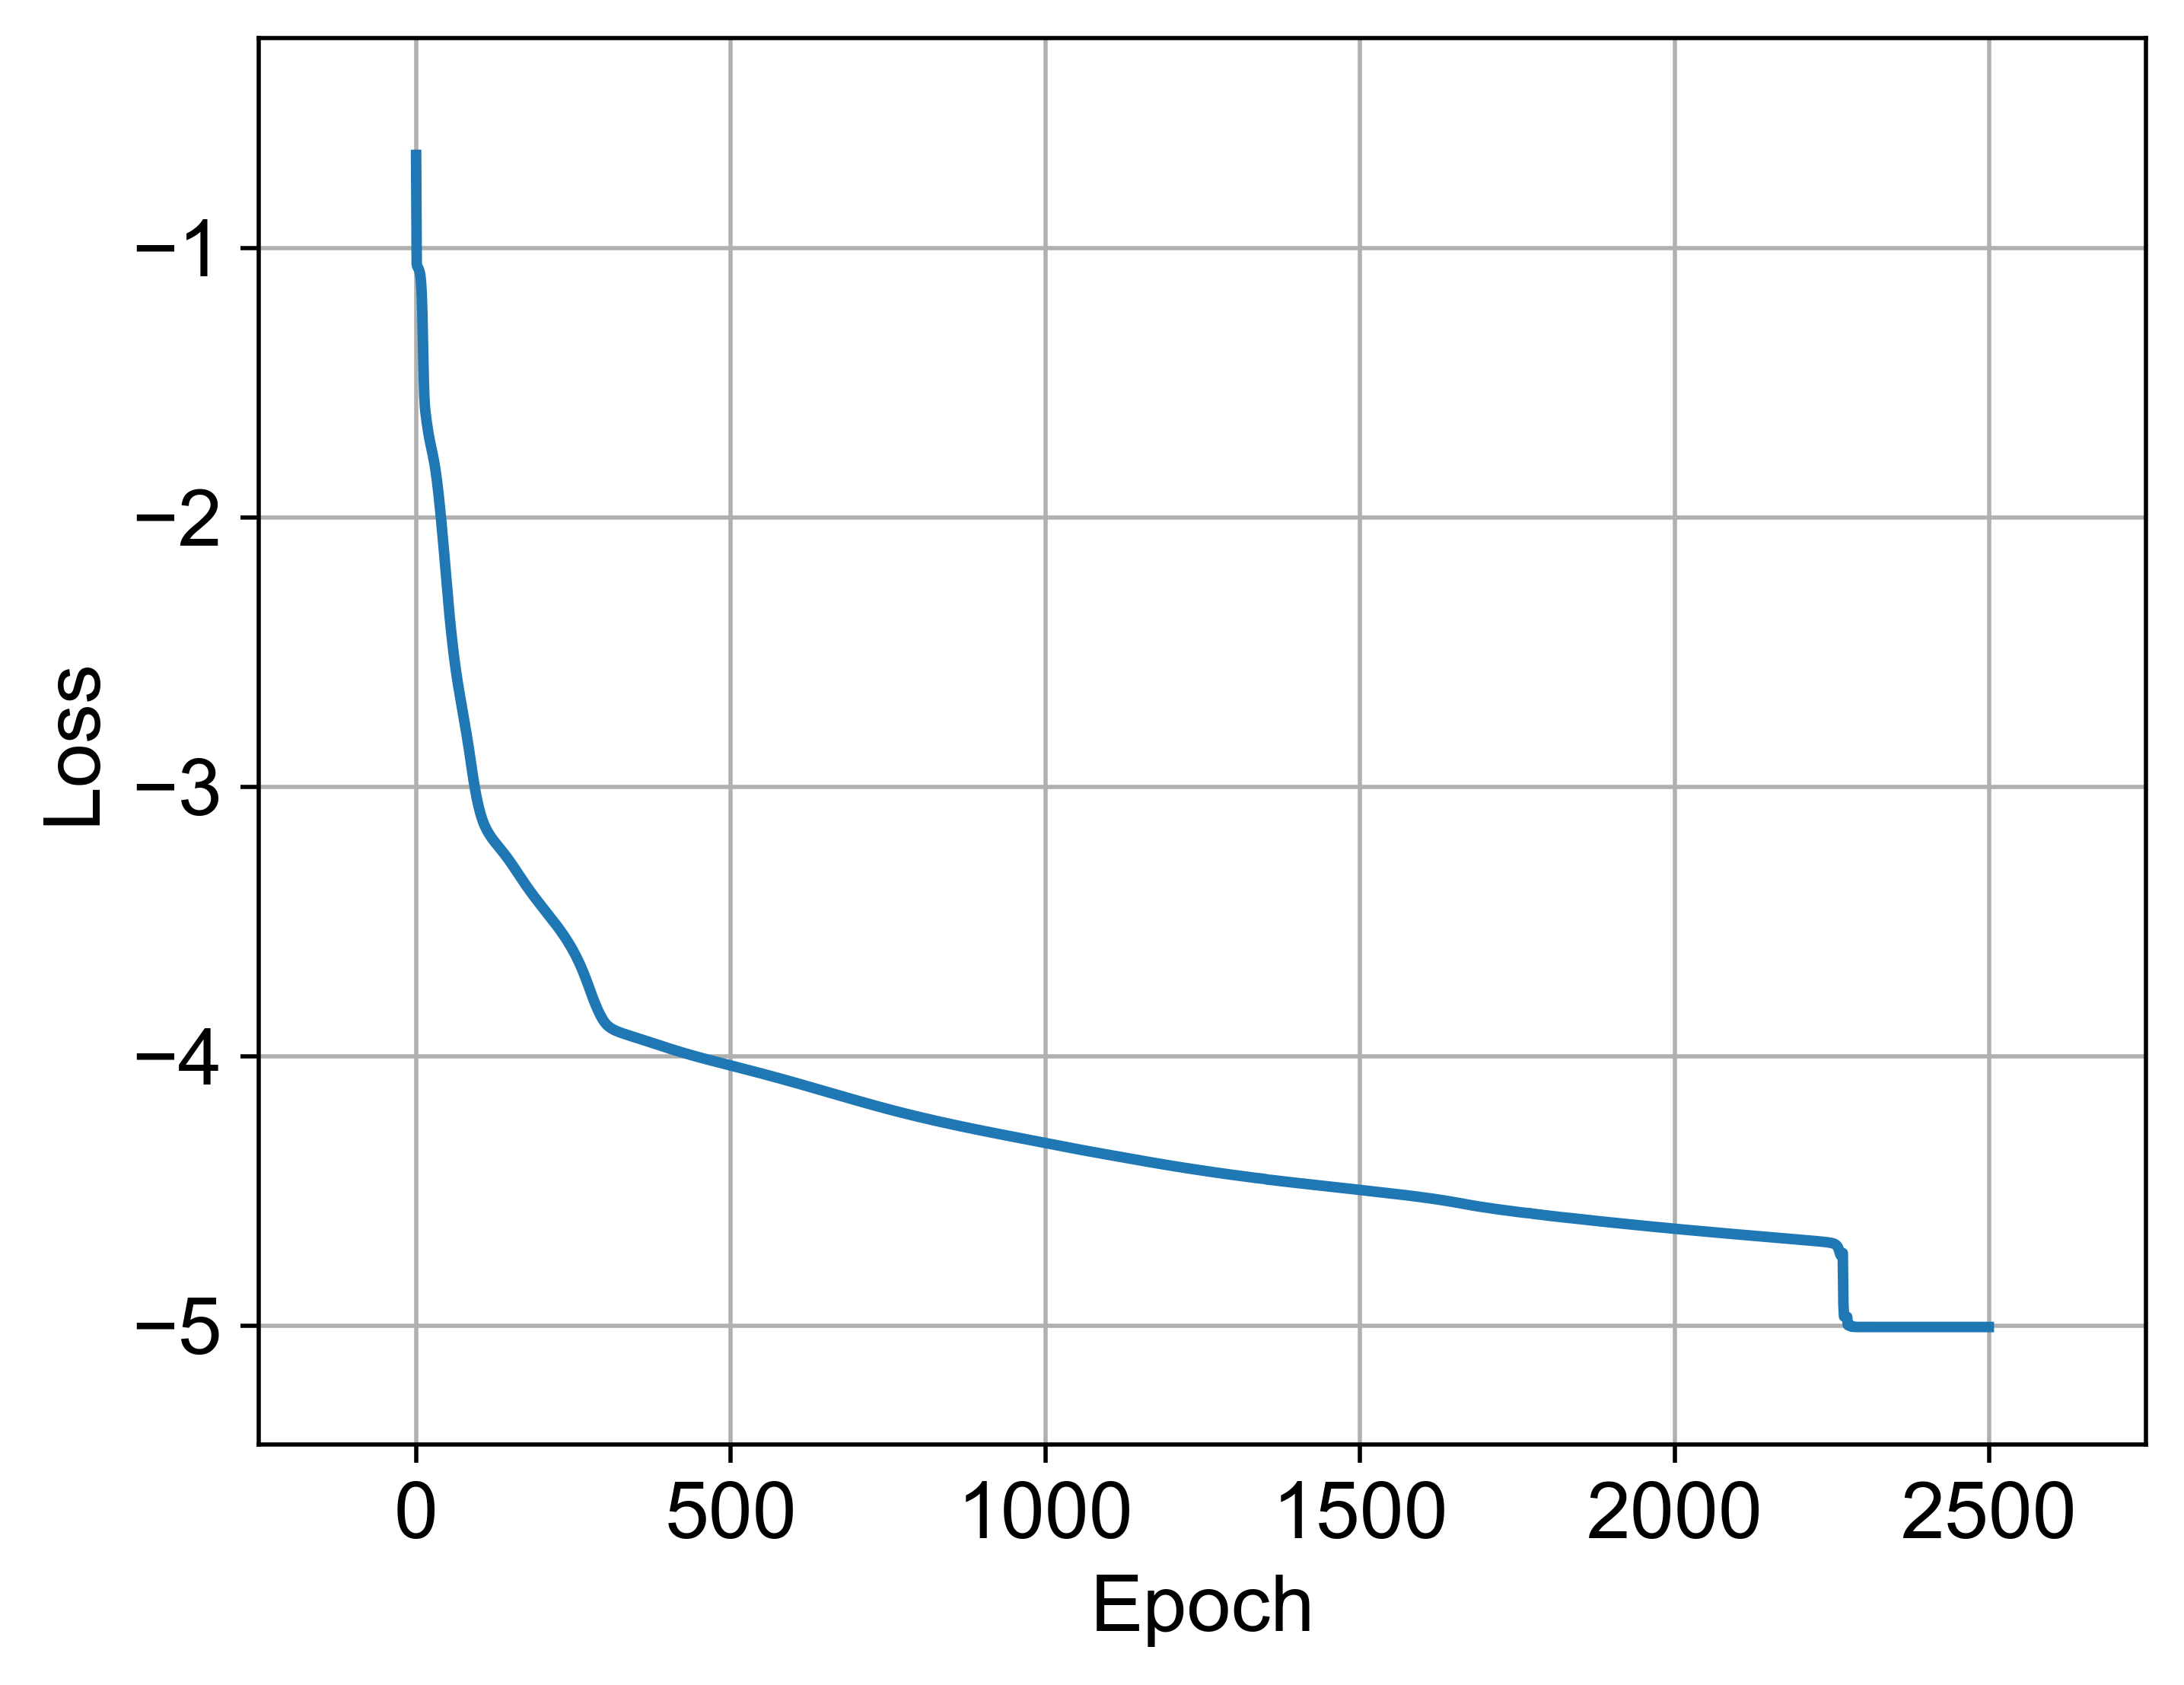

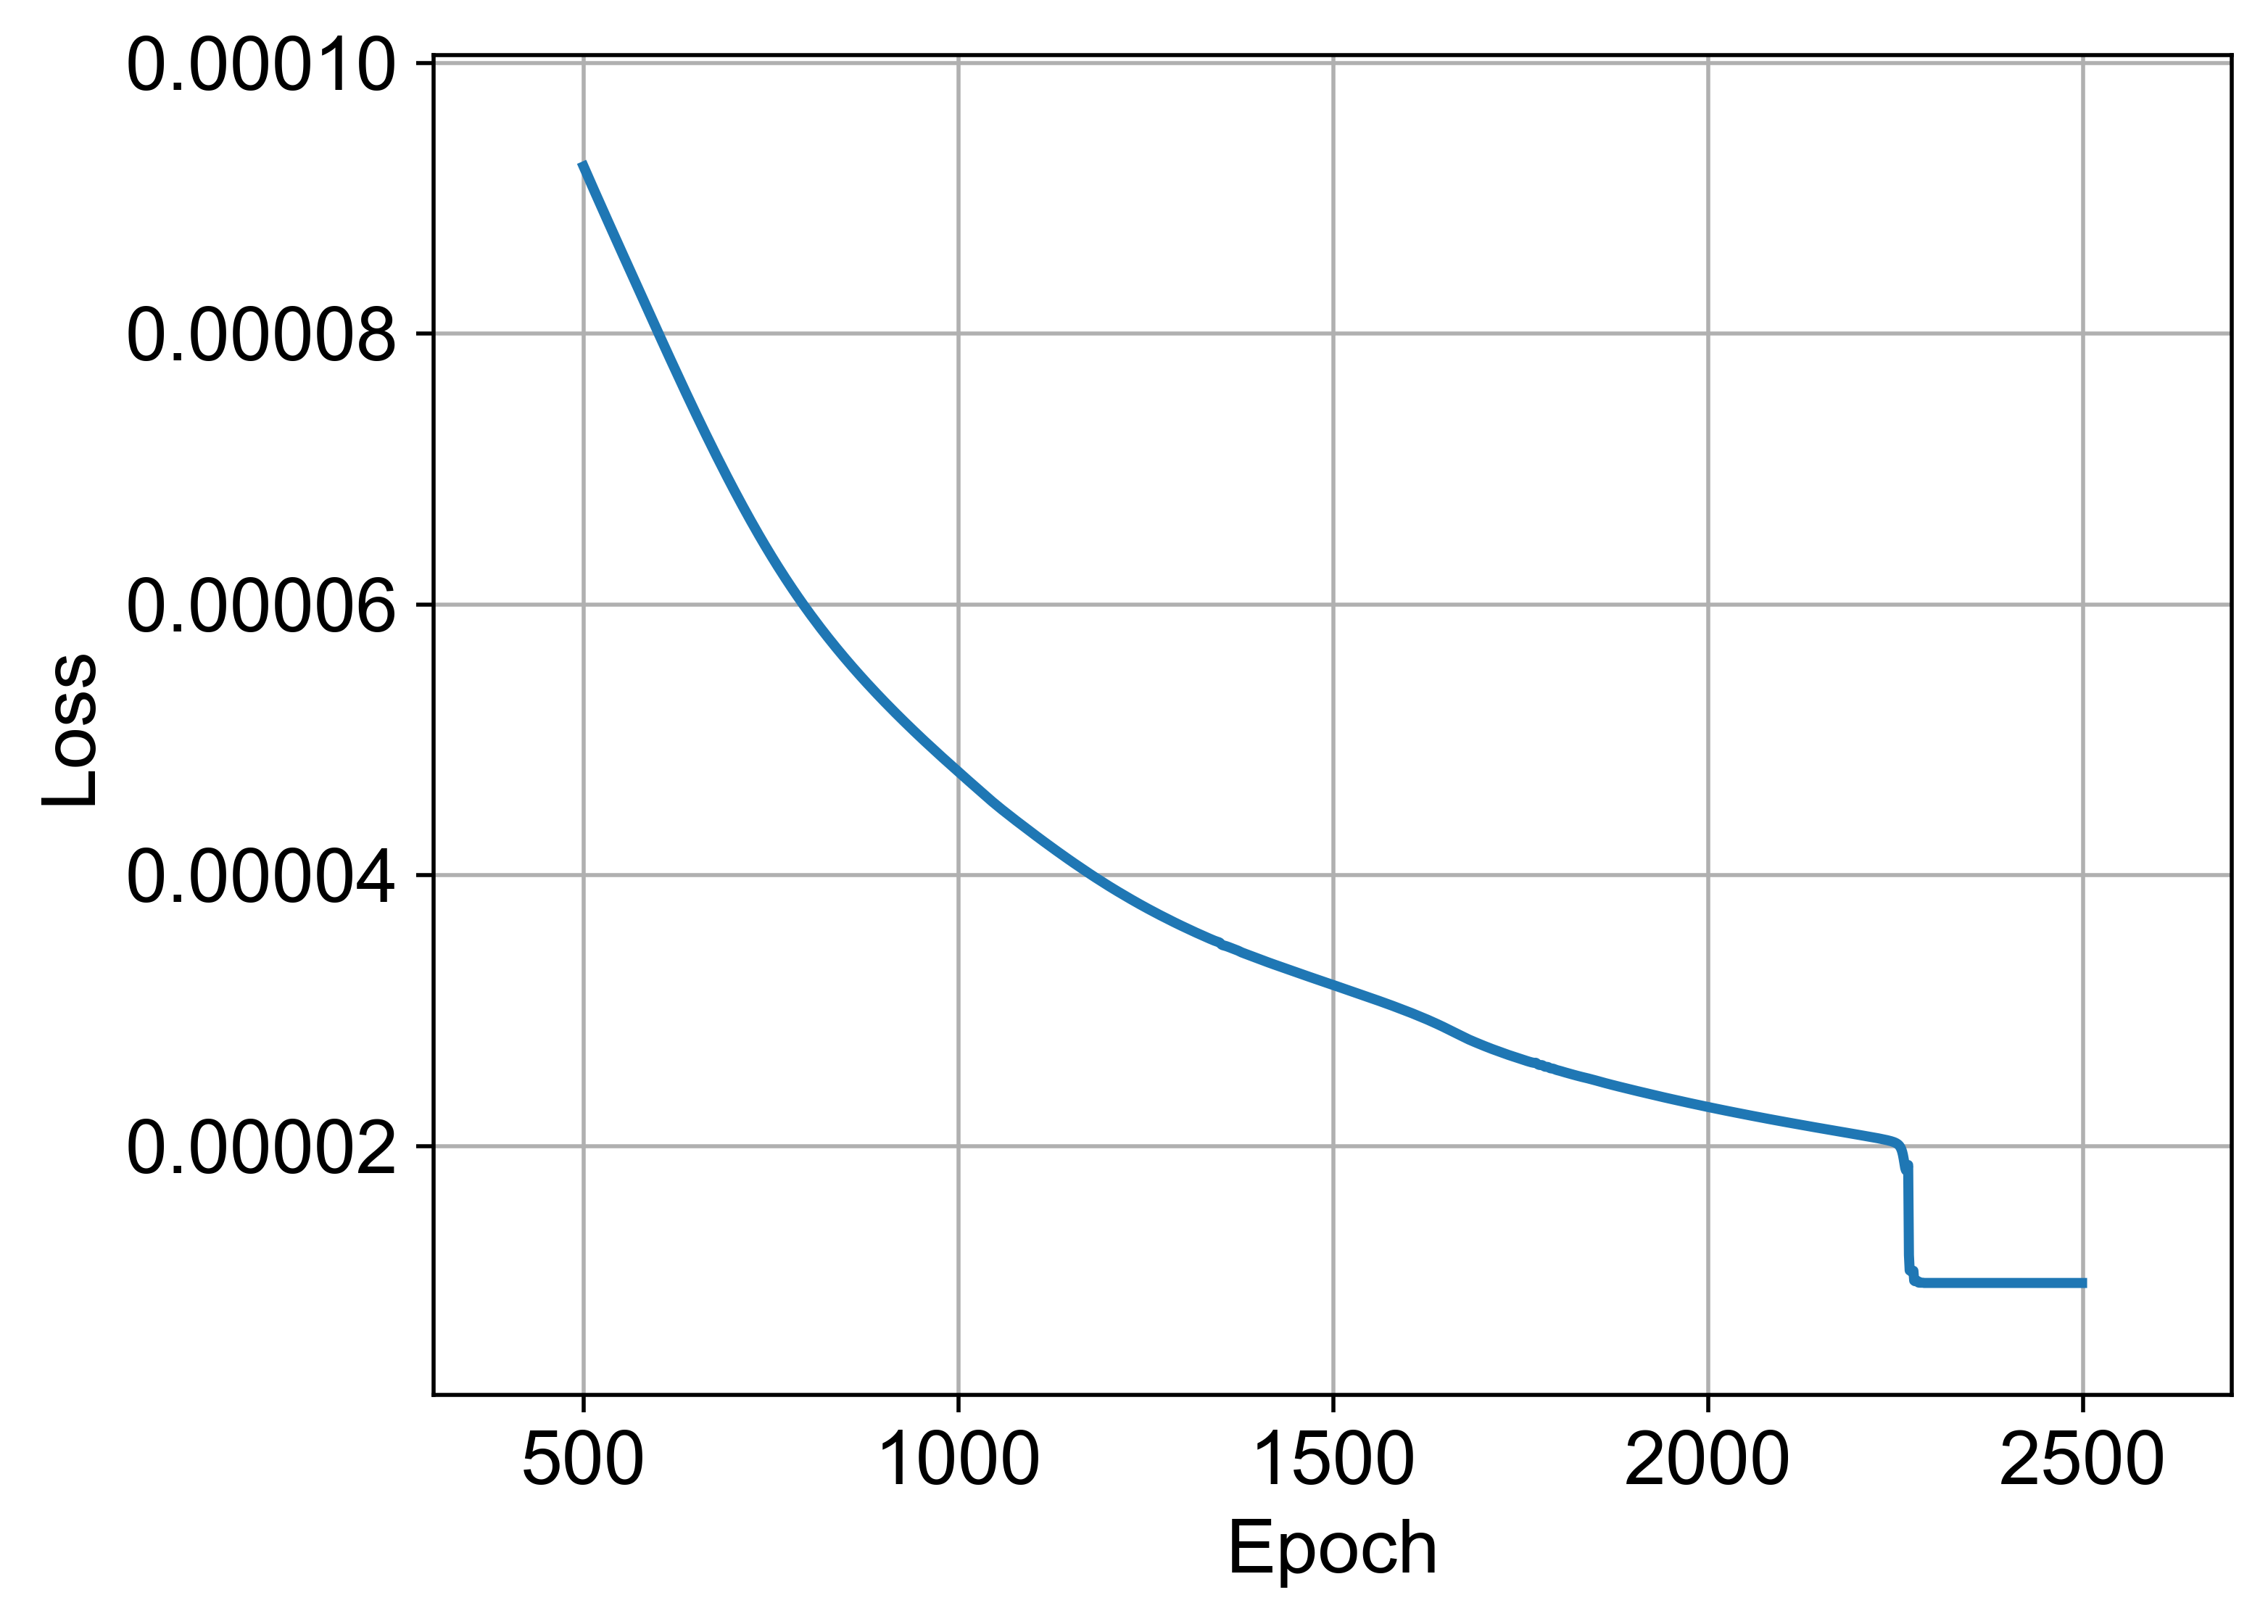

In [ ]:
from re import L
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from torch import optim
from torch.utils import data
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


import statistics
import datetime
import os
import csv
import math
import time
import numpy as np
import os

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.getcwd()

start = time.time()

idvg_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/thermal-dmode-iv.csv', encoding='utf8')
cv_temp = pd.read_csv(r'/content/drive/MyDrive/Colab_ML_ProfYu/csv_data/cv_iwo_0212_dataset.csv', encoding='utf8')
#cv_temp=pd.read_csv(r'./cv_iwo_0206.csv', encoding='utf8')
# idvg=idvg_temp.values

temperature = [25, 55, 85]
vd_temp=[0.05, 0.1, 1, 3, 6, 9, 12] #0.3
vd = np.array(vd_temp)
vg_temp=idvg_temp.iloc[:,0]
vg = np.array(vg_temp.values)
temperature = np.array(temperature)

def Logset(target):
    temp = np.array(target)
    # temp[temp<0]=abs(temp)
    # temp = temp.tolist() not use
    temp = np.log10(temp)
    return temp

It = []
for l in list(range(len(temperature))):
    for i in list(range(len(vd))):
        temp = idvg_temp.iloc[:, 2*i+1+2*len(vd)*l]
        temp = np.array(temp.values)
        It.extend(temp)

It = Logset(It)
# vd = Logset(vd)

def normaliz(target): #Minmax normalization
    Min = min(target)
    Val = target-Min
    Val = Val
    Max = max(Val)
    Norm = 1/Max
    return (Norm, Val, Min)

(normVg, Vg_1, MinVg)=normaliz(vg)
(normVd, Vd_1, MinVd)=normaliz(vd)
(normIt, It_1, MinIt)=normaliz(It)
(normTemperature, Temperature_1, MinTemperature) = normaliz(temperature)
print(MinVd)
print(normVd)

Vg = normVg*Vg_1
Vd = normVd*Vd_1
I = normIt*It_1
Temperature = normTemperature*Temperature_1

datasets = []
for l in list(range(len(Temperature))):
    for i in list(range(len(vd))):
        for j in list(range(len(vg))):
            temp=[Vg[j],Vd[i],Temperature[l], I[j+len(vg)*(i+len(vd)*l)]]
            datasets.append(temp)

V = []
for i in list(range(len(datasets))):
    temp = [datasets[i][0], datasets[i][1], datasets[i][2]]
    V.append(temp)

I = []
for i in list(range(len(datasets))):
    temp = [datasets[i][3]]
    I.append(temp)

V = torch.tensor(V)
I = torch.tensor(I)

# dataset = list(zip(V, I))
x_train, x_test, y_train, y_test = train_test_split(V, I, test_size=0.1, random_state=41)
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32)
testdataloader = DataLoader(TensorDataset(x_test, y_test))

# print(idvg_temp.values)
It_g = [10**x for x in It]
CM_git = np.corrcoef(vg,It_g[len(vg)*10:len(vg)*11])
Itd=[]
print(len(It_g))
print(len(vg))
print(len(vd))
print(len(temperature))

for i in list(range(len(vd))):
    Itd.append(It_g[len(vg)-23+len(vg)*i])
print(Itd)
CM_dit = np.corrcoef(vd, Itd)

print(temperature)
print()
Itl = []
print(It_g[len(vg)*len(vd)-4])
#print(It_g[len(vg)*len(vd)*8-4])
print(list(range(len(temperature))))
for i in list(range(len(temperature))):
    Itl.append(It[len(vg)*len(vd)*(i+1)-20] )
print(Itl)
CM_lit = np.corrcoef(Temperature, Itl)

print(CM_git)
print(CM_dit)
print(CM_lit)

n1 = 25
n2 = 15
# Define the neural network class
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(3, n1)
        self.fc2 = torch.nn.Linear(n1, n2)
        self.fc3 = torch.nn.Linear(n2, 1)
        self.dropout = torch.nn.Dropout(0.2)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.elu = torch.nn.ELU(1.0)
        self.Softsign = torch.nn.Softsign()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.bn1 = torch.nn.BatchNorm1d(25)
        self.bn2 = torch.nn.BatchNorm1d(12)
        self.bn3 = torch.nn.BatchNorm1d(1)

    def forward(self, x):
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.tanh(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        return x

# Create an instance of the MLP class
model = MLP()

torch.nn.init.xavier_uniform(model.fc1.weight)
torch.nn.init.xavier_uniform(model.fc2.weight)
torch.nn.init.xavier_uniform(model.fc3.weight)
# torch.nn.init.xavier_uniform(model.fc4.weight)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# losses = []
# criterion = nn.MSELoss() # <== 파이토치에서 제공하는 평균 제곱 오차 함수\

nb_epochs = 2500
MLoss = []
for epoch in range(0, nb_epochs):

    current_loss = 0.0
    losses = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(dataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        L_weight = 3
        #compute loss
        batch_loss = []
        for j in range(inputs.size(0)):
            input_j = inputs[j].reshape((1, inputs.shape[1]))
            if input_j[0,0]>0.3:
                batch_loss.append(L_weight*loss_function(outputs[j], targets[j]))
            else:
                batch_loss.append(loss_function(outputs[j], targets[j]))

        loss = torch.stack(batch_loss).mean()

        losses.append(loss.item())

        #perform backward pass
        loss.backward()
        #perform optimization
        optimizer.step()
        # Print statistics

    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

#print('Loss (epoch: %4d): %.8f' %(epoch+1, mean_loss))
# Print the loss only every 10 epochs
    if (epoch + 1) % 10 == 0:
        print('Loss (epoch: %4d): %.8f' % (epoch + 1, mean_loss))
    current_loss = 0.0
    MLoss.append(mean_loss)
    optimizer.step()
        # Print statistics
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)


# Process is complete.
print('Training process has finished.')

torch.save(model, 'IWO_idvg.pt')
torch.save(model.state_dict(), 'IWO_idvg_state_dict.pt')

####### loss vs. epoch #######
xloss = list(range(0, nb_epochs))
plt.plot(xloss, np.log10(MLoss))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(xloss[500:], MLoss[500:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Training process has finished.


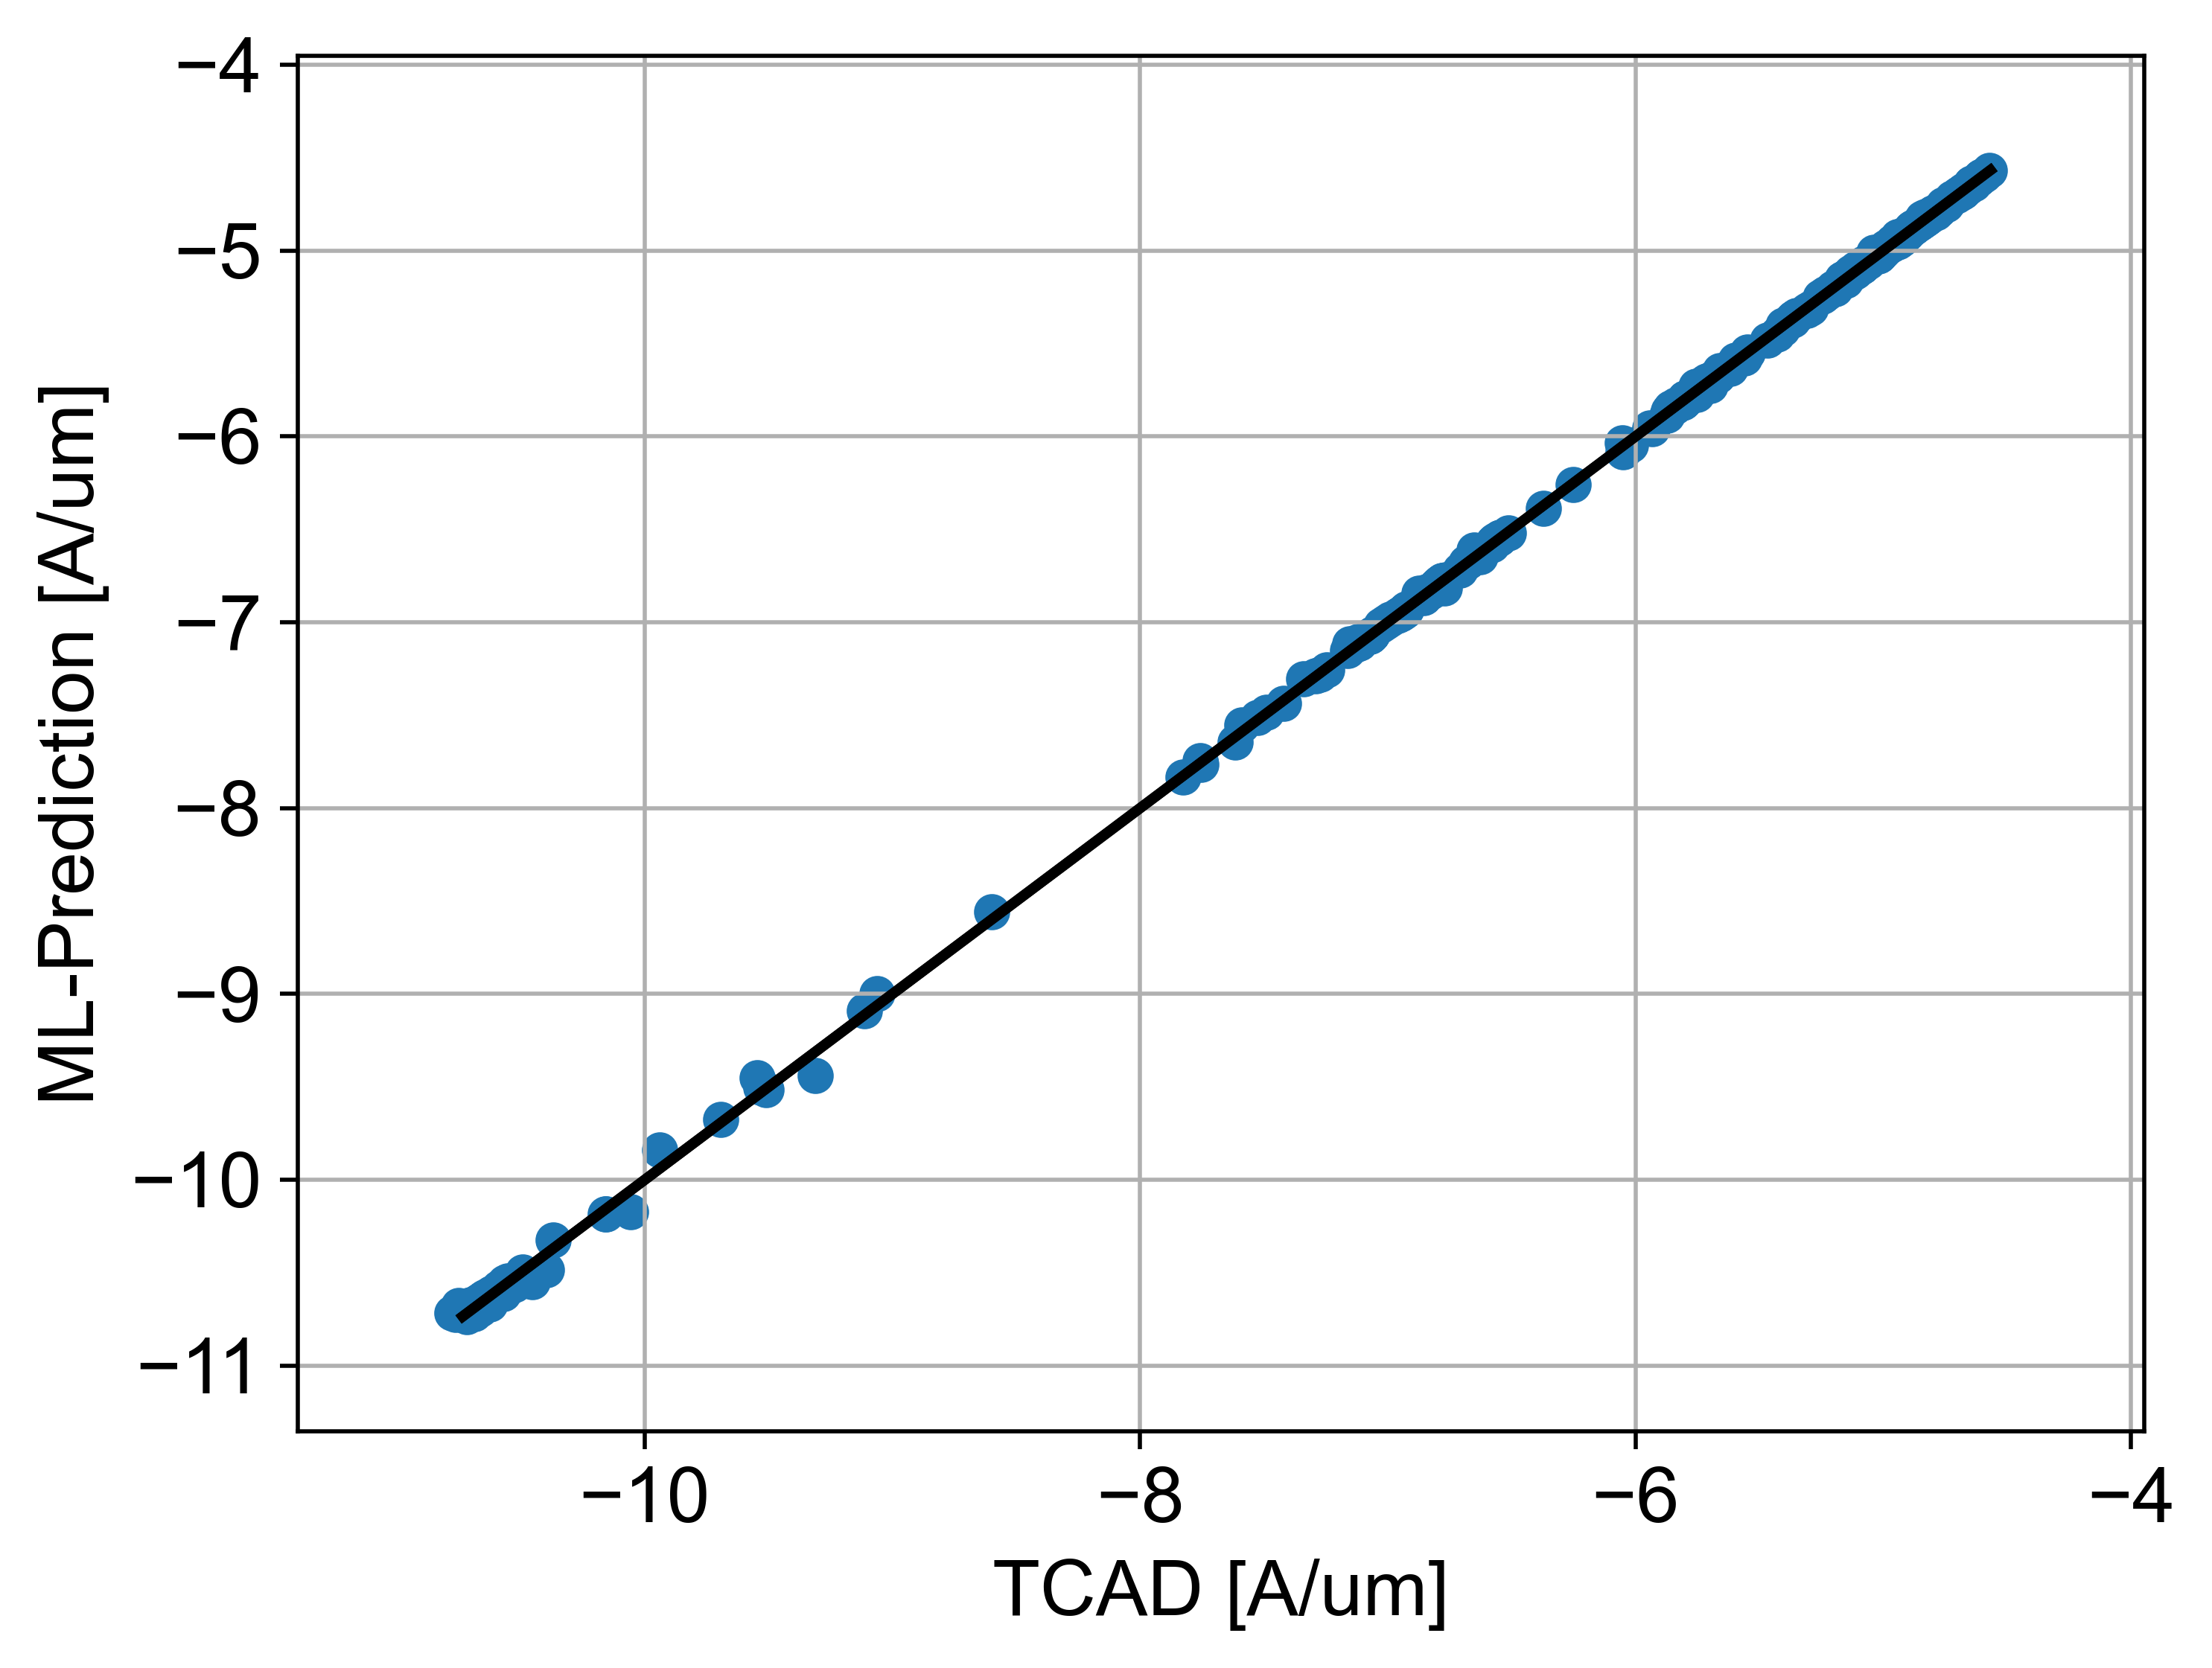

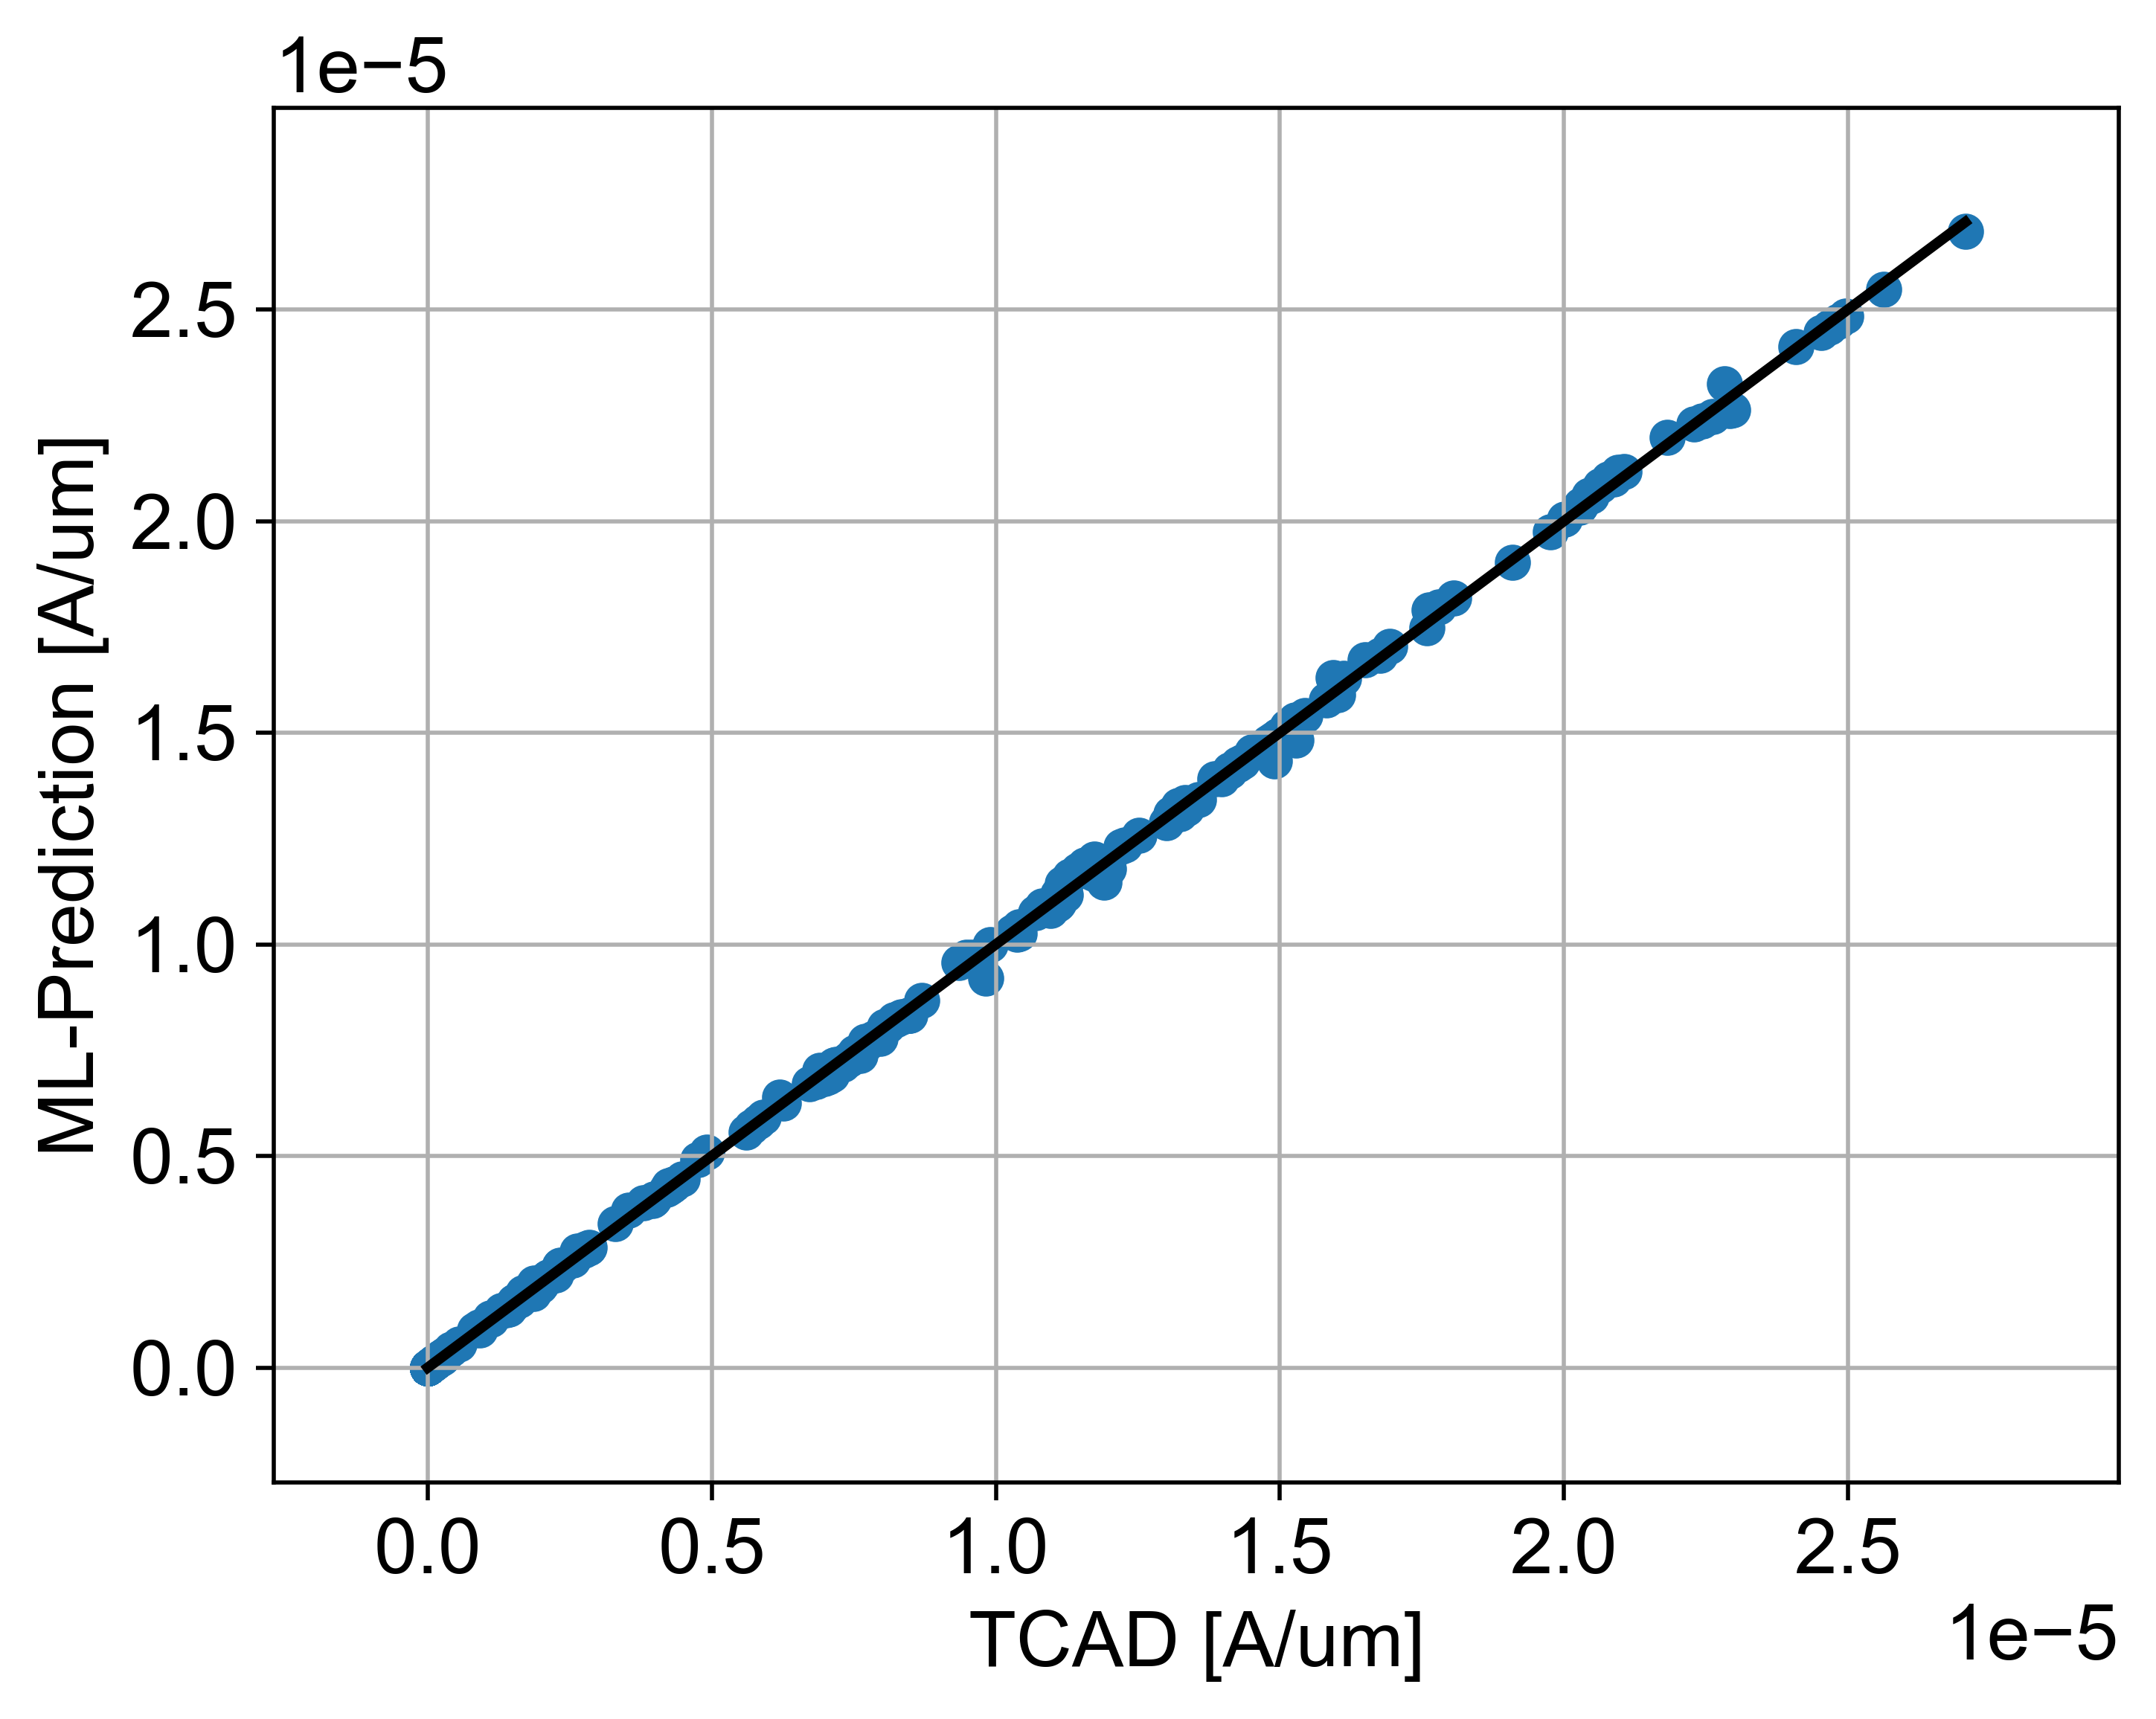

In [ ]:
import matplotlib as mat
from matplotlib import font_manager, rc

def setPlotStyle():
    arial_font_path = '/content/drive/MyDrive/Colab_ML_ProfYu/ML_model_save/Arial.ttf'
    font_prop = font_manager.FontProperties(fname=arial_font_path)
    font_manager.fontManager.addfont(arial_font_path)
    mat.rcParams['font.family'] = font_prop.get_name()
    #mat.rc('font', family='sans-serif')
    #mat.rc('font', serif='Helvetica Neue')
    #mat.rc('text', usetex='false')
    mat.rcParams['font.size'] = 15
    mat.rcParams['legend.fontsize'] = 15
    mat.rcParams['lines.linewidth'] = 2
    mat.rcParams['axes.grid'] = True
    mat.rcParams['axes.xmargin'] = 0.1
    mat.rcParams['axes.ymargin'] = 0.1
    #mat.rcParams['mathtext.fontset'] = 'dejavuserif'
    mat.rcParams['figure.dpi'] = 500
    mat.rcParams['savefig.dpi'] = 500

setPlotStyle()

with torch.no_grad():

    output = []
    # Iterate over the dataloader for training data
    for i, data in enumerate(testdataloader, 0):
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0],1))

        #zero the gradients
        optimizer.zero_grad()

        #perform forward pass
        outputs = model(inputs)
        output.append(outputs)
# Process is complete.
print('Training process has finished.')

output1 = np.power(10, output/normIt+MinIt)
ytest1 = np.power(10, y_test/normIt+MinIt)
plt.scatter(np.log10(output1), np.log10(ytest1))
a = [min(ytest1), max(ytest1)]
b = [min(ytest1), max(ytest1)]
plt.plot(np.log10(a), np.log10(b), 'k')
plt.plot(np.log10(a), np.log10(b), 'k')

plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()

plt.plot(a,b,'k')
plt.scatter(ytest1,output1)
plt.xlabel("TCAD [A/um]")
plt.ylabel("ML-Prediction [A/um]")
plt.show()


[1.07229e-07, 2.15974e-07, 1.98669e-06, 4.98005e-06, 7.6723e-06, 8.94722e-06, 9.68852e-06]
[1.41176e-07, 2.81676e-07, 2.65421e-06, 7.33507e-06, 1.37095e-05, 1.96717e-05, 2.54634e-05]
[1.51636e-07, 3.02327e-07, 2.85767e-06, 7.94724e-06, 1.49947e-05, 2.1828e-05, 2.86111e-05]


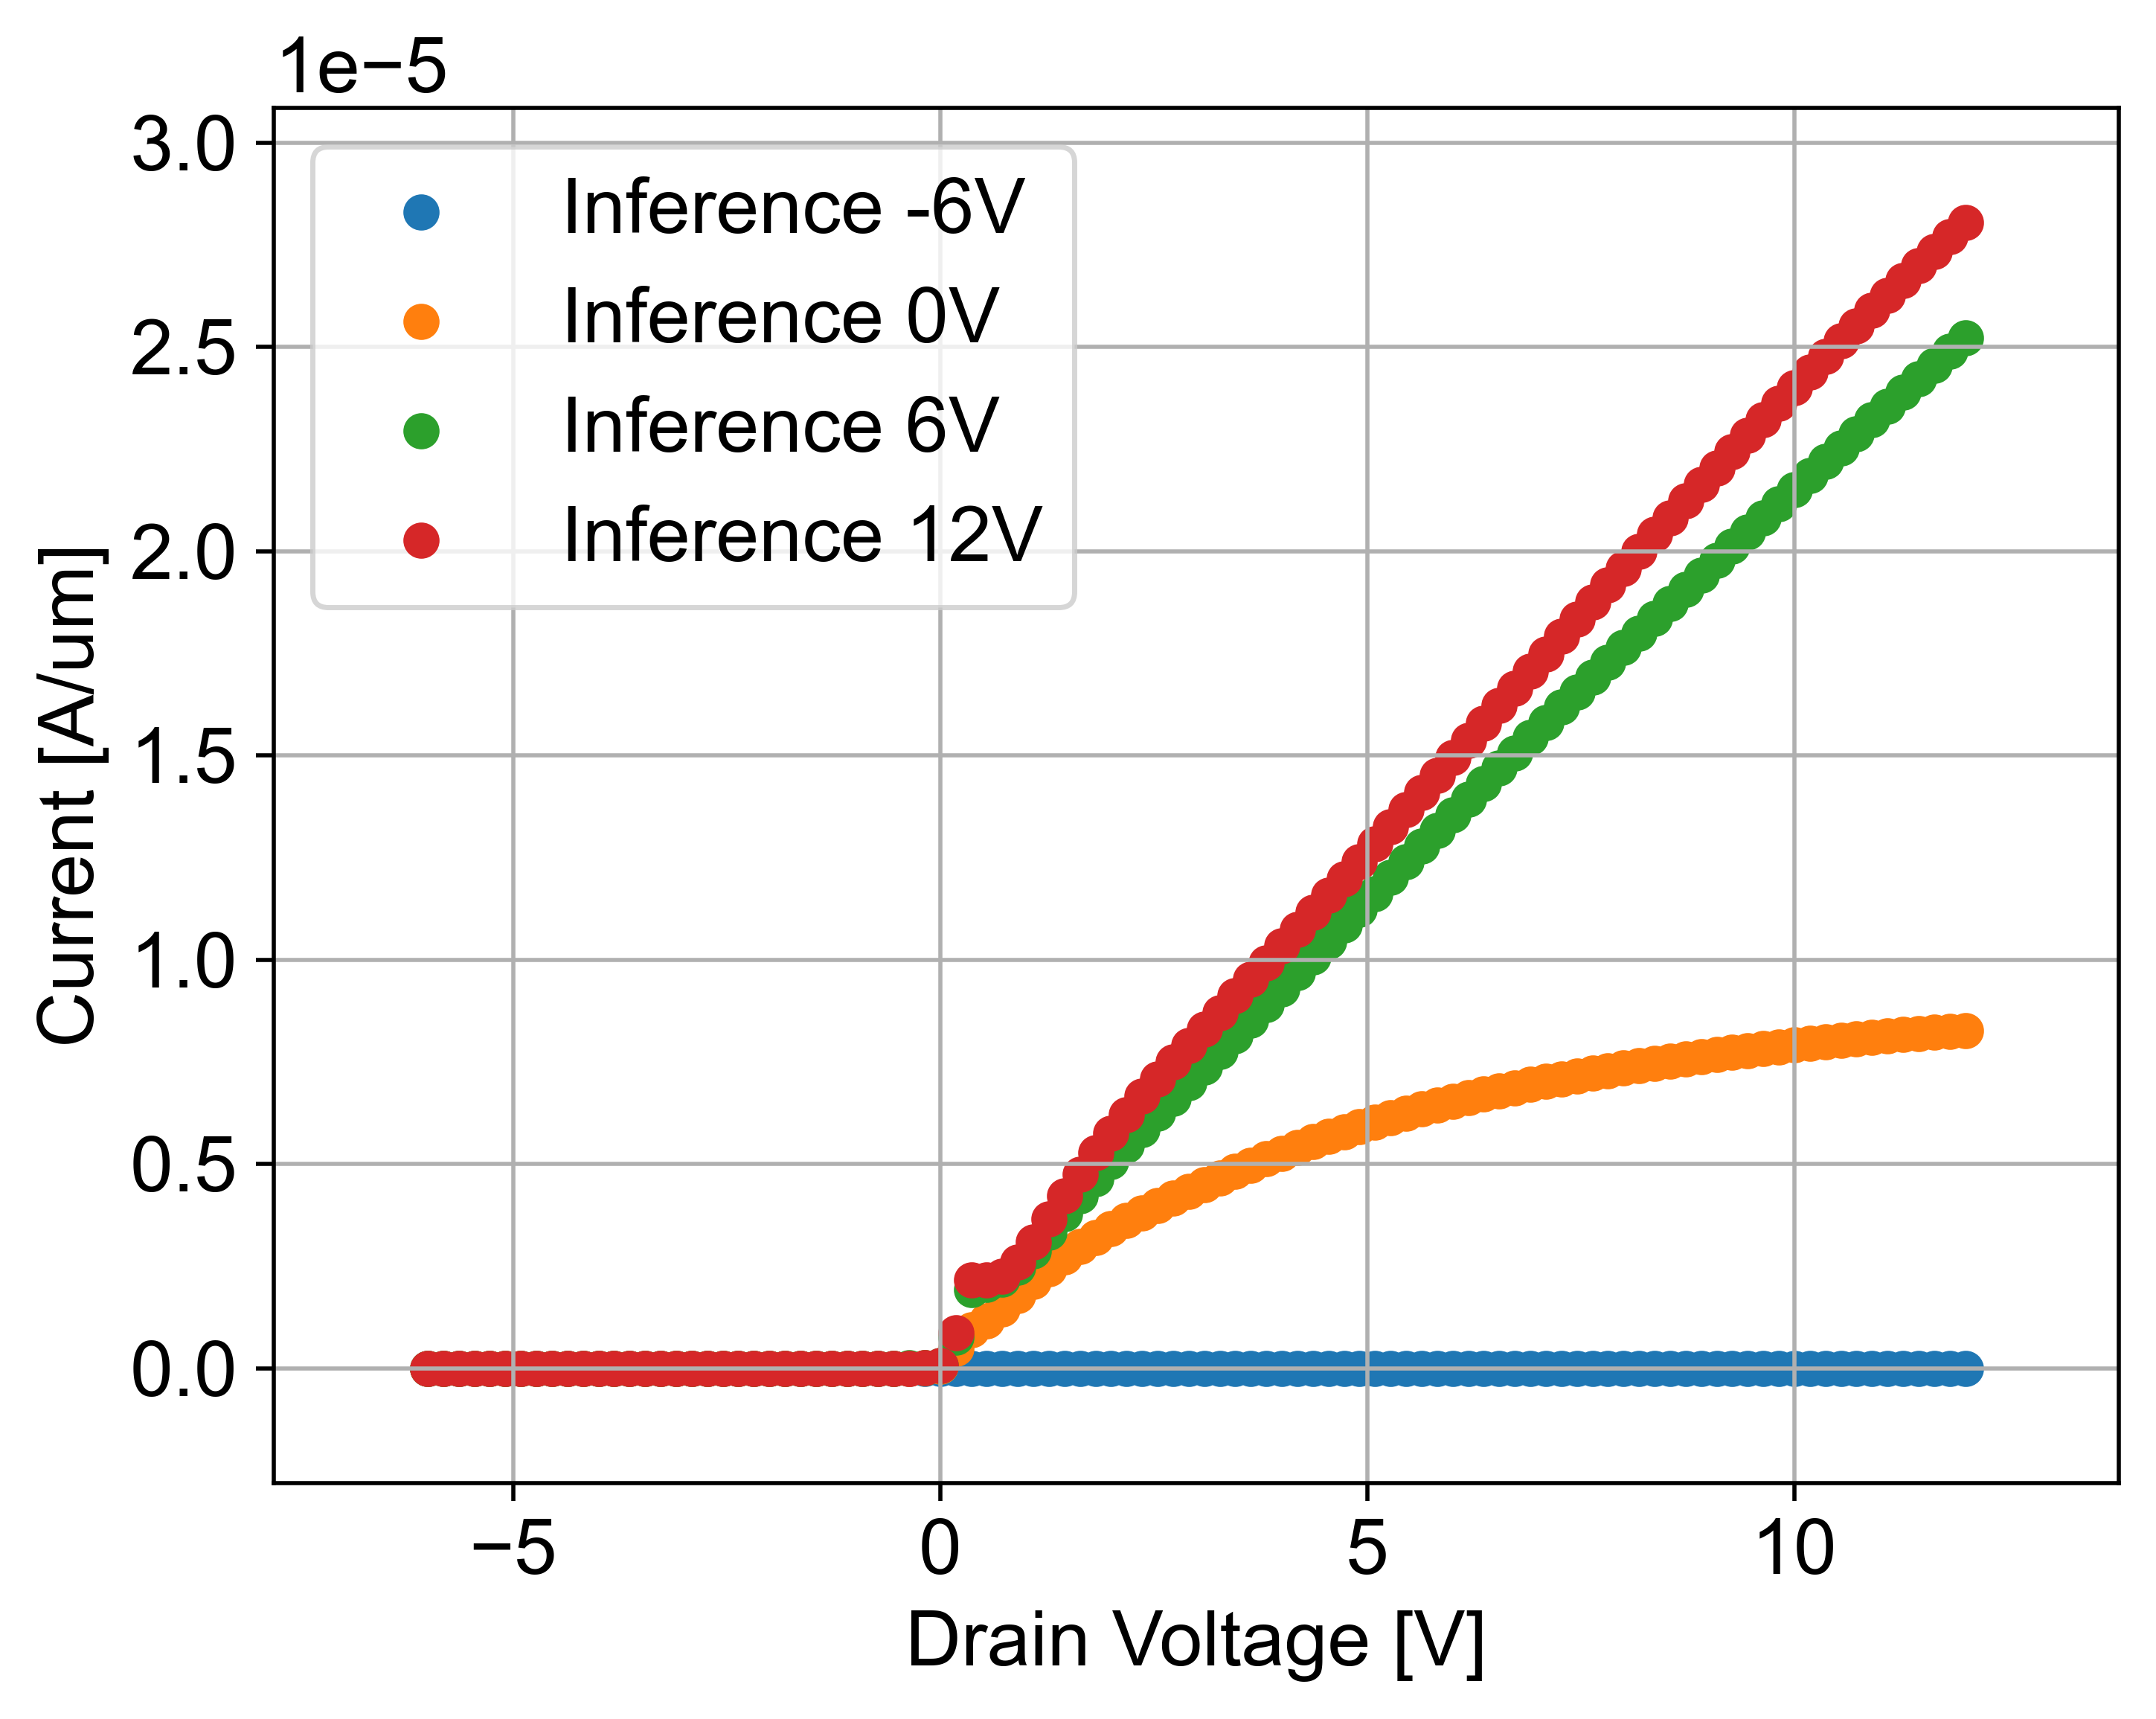

'\nplt.plot(Vd_test, Id05_test) ## TCAD\nplt.plot(Vd_test, Id1_test) ## TCAD\nplt.scatter(x_test, I_final)\nplt.scatter(x_test, I_final1)\nplt.xlabel("Drain Voltage [V]")\nplt.ylabel("Current [A/um]")\nplt.legend()\nplt.show()\n'

In [ ]:
temp_inference = 85
######################### IDVD Vg=0.8 ##############################
x_test = np.linspace(-6, 12, num=100)
#print(x_test)
# x_test = Logset(x_test.tolist())
X= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(-6-MinVg)*normVg, (x_test[i]-MinVd)*normVd, 0]
    X.append(temp)

Pred_y=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X[i])
    pred_y=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y.append(pred_y)

I_pred =[np.power(10, i/normIt+MinIt) for i in Pred_y]

I_pred=np.array(I_pred)

I_final= []
for i in list(range(len(I_pred))):
    I_final.extend(I_pred[i])

######################### vg=1.7 IDVD ##############################

X1= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(0-MinVg)*normVg, (x_test[i]-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
    X1.append(temp)

Pred_y1=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X1[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y1.append(pred_y15)

I_pred1 =[np.power(10, i/normIt+MinIt) for i in Pred_y1]

I_pred1=np.array(I_pred1)

I_final1= []
for i in list(range(len(I_pred1))):
    I_final1.extend(I_pred1[i])

    ######################### vg=2.6 IDVD ##############################

X15= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(6-MinVg)*normVg, (x_test[i]-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
    X15.append(temp)

Pred_y15=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X15[i])
    pred_y15=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y15.append(pred_y15)

I_pred15 =[np.power(10, i/normIt+MinIt) for i in Pred_y15]

I_pred15=np.array(I_pred15)

I_final15= []
for i in list(range(len(I_pred15))):
    I_final15.extend(I_pred15[i])

############# Vg = 3.5 IDVD ######################

X25= []
# X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
for i in list(range(len(x_test))):
    temp=[(12-MinVg)*normVg, (x_test[i]-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
    X25.append(temp)

Pred_y25=[]
for i in list(range(len(x_test))):
    new_var =  torch.FloatTensor(X25[i])
    pred_y25=model(new_var).data.numpy()
    # Tolist=pred_y.tolist()
    Pred_y25.append(pred_y25)

I_pred25 =[np.power(10, i/normIt+MinIt) for i in Pred_y25]

I_pred25=np.array(I_pred25)

I_final25= []
for i in list(range(len(I_pred25))):
    I_final25.extend(I_pred25[i])

#
Vd_test = np.linspace(0, 12, num=7) #[0.05, 0.1, 1, 3, 6, 9, 12]

#Id05_test =   [0.000002334528,	0.000002794075,	0.0000034787794,	0.0000041579335,	0.0000050547895,	0.0000061619935,	0.0000076860329,	0.0000091797256,	0.00001105585,	0.000013479929,	0.000016007828,	0.000019161787,	0.000022833255,	0.000026916777,	0.000031624447,	0.00003715309,	0.000043519255,	0.000051091182,	0.000059951515,	0.000070285433,	0.000081658741,	0.00009342872,	0.00010362595,	0.00011101203,	0.00011523482,	0.00011676641,	0.00011730475,	0.00011770665,	0.00011801129,	0.00011824027]
#Id1_test = [0.0000068904883,	0.0000082636631,	0.000010320372,	0.000012373432,	0.000015105188,	0.000018510854,	0.000023262079,	0.000027993958,	0.000034049704,	0.000042075633,	0.000050709182,	0.000061905496,	0.000075594373,	0.000091696572,	0.0001113915,	0.0001351759,	0.00016354498,	0.00019827644,	0.00024007196,	0.00029160991,	0.00035507471,	0.00043267721,	0.00052608063,	0.00063305815,	0.0007463102,	0.0008524028,	0.00094690883,	0.0010169456,	0.0010548491,	0.0010714827]
#Id15_test = [0.000010230849,	0.000012273384,	0.000015334923,	0.000018393846,	0.000022468346,	0.000027555048,	0.000034664693,	0.000041761002,	0.000050865865,	0.00006297397,	0.000076052026,	0.000093097636,	0.0001140765,	0.00013895091,	0.00016967963,	0.00020724046,	0.00025268947,	0.00030923446,	0.00037849644,	0.00046572552,	0.00057601516,	0.00071607664,	0.00089446014,	0.0011176712,	0.0013874073,	0.0016982907,	0.0020232064,	0.0023477774,	0.0026028589,	0.002758771]
#Id_test =  [0.000012969341,	0.000015560565,	0.000019445809,	0.000023329203,	0.000028504135,	0.000034968453,	0.000044010611,	0.000053044062,	0.000064646594,	0.000080097706,	0.000096815121,	0.000118649,	0.00014559015,	0.00017764185,	0.00021740052,	0.0002662518,	0.00032573661,	0.0004003178,	0.00049245958,	0.00060963036,	0.00075939393,	0.00095209114,	0.0012021121,	0.0015230151,	0.0019258635,	0.0024179715,	0.0029806776,	0.003633391,	0.0042757708,	0.0047633642]
Id05_test = list(idvg_temp.iloc[0, 1:]) # -6V
Id1_test = list(idvg_temp.iloc[61, 1:]) # 0V
Id15_test = list(idvg_temp.iloc[121, 1:]) # 6V
Id_test = list(idvg_temp.iloc[180, 1:]) # 12V 183?
def remove_nan(values):
    return [x for x in values if not np.isnan(x)]
Id05_test = remove_nan(Id05_test)
Id1_test = remove_nan(Id1_test)
Id15_test = remove_nan(Id15_test)
Id_test = remove_nan(Id_test)

Id05_test = Id05_test[14:] # 1, 8, 15
Id1_test = Id1_test[14:]
Id15_test = Id15_test[14:]
Id_test = Id_test[14:]
#x_test = np.power(10, x_test)

print(Id1_test)
print(Id15_test)
print(Id_test)

#plt.plot(Vd_test, Id05_test, label = 'Actual -6V') ## TCAD
#plt.plot(Vd_test, Id1_test, label = 'Actual 0V') ## TCAD
#plt.plot(Vd_test, Id15_test, label = 'Actual 6V') ## TCAD
#plt.plot(Vd_test, Id_test, label = 'Actual 12V') ## TCAD
plt.scatter(x_test, I_final, label = 'Inference -6V')
plt.scatter(x_test, I_final1, label = 'Inference 0V')
plt.scatter(x_test, I_final15, label = 'Inference 6V')
plt.scatter(x_test, I_final25, label = 'Inference 12V')
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()
"""
plt.plot(Vd_test, Id05_test) ## TCAD
plt.plot(Vd_test, Id1_test) ## TCAD
plt.scatter(x_test, I_final)
plt.scatter(x_test, I_final1)
plt.xlabel("Drain Voltage [V]")
plt.ylabel("Current [A/um]")
plt.legend()
plt.show()
"""
#print(np.round(x_test, 3).tolist)
#print(I_final)
#print(I_final1)
#print(I_final15)
#print("")


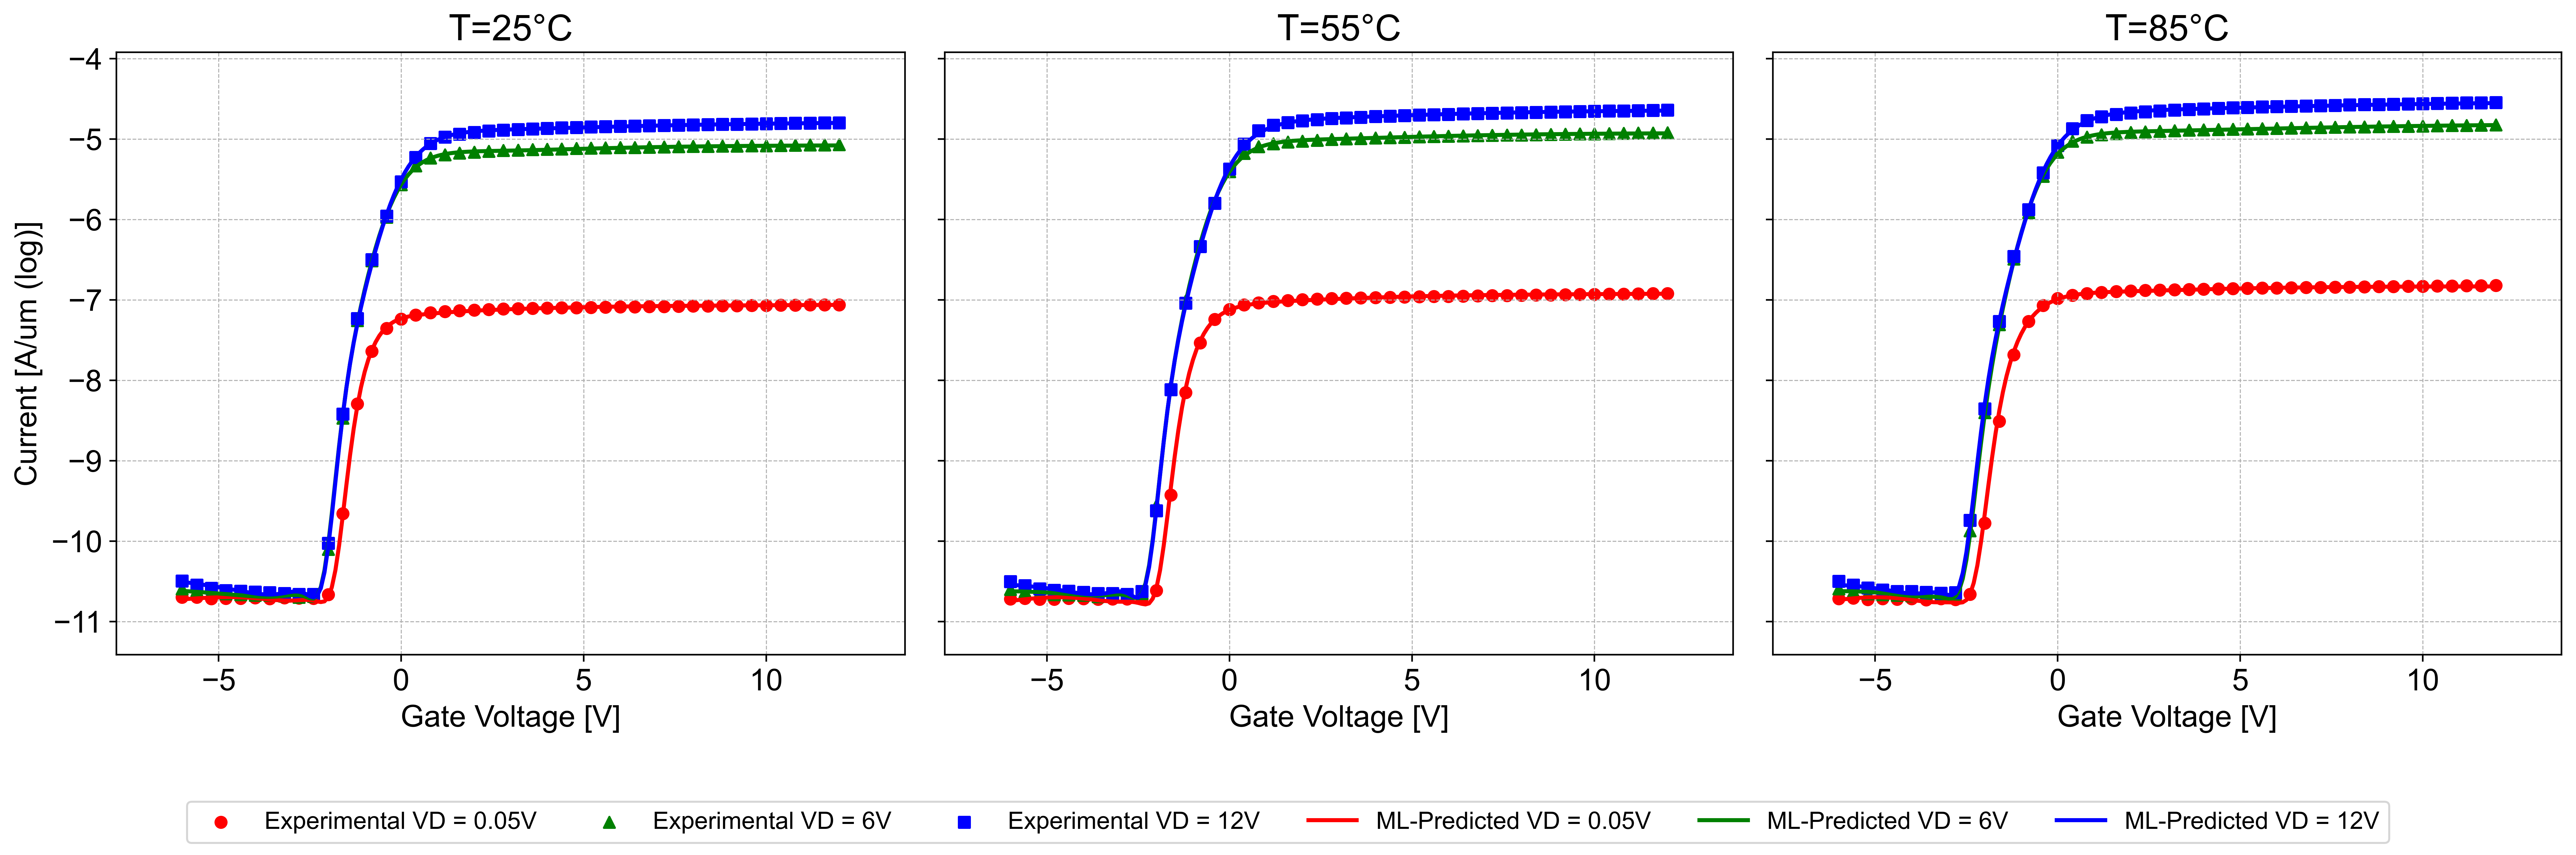

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def Iv_inference(temp_inference):
    xv_test = list(range(-60, 120, 1))
    xv_test = np.array(xv_test)/10
    Xv= []
    # X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
    for i in list(range(len(xv_test_1))):
        temp=[(xv_test[i]-MinVg)*normVg, ((0.05)-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
        Xv.append(temp)

    Predv_y=[]
    for i in list(range(len(xv_test_1))):
        new_var =  torch.FloatTensor(Xv[i])
        pred_y=model(new_var).data.numpy()
        # Tolist=pred_y.tolist()
        Predv_y.append(pred_y)

    Iv_pred =[np.power(10, i/normIt+MinIt) for i in Predv_y]

    Iv_pred=np.array(Iv_pred)

    Iv_final= []
    for i in list(range(len(Iv_pred))):
        Iv_final.extend(Iv_pred[i])

    #### VD =1.042V ####

    Xv11=[]
    for i in list(range(len(xv_test))):
        temp=[(xv_test[i]-MinVg)*normVg, ((6)-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
        Xv11.append(temp)

    Predv_y11=[]
    for i in list(range(len(xv_test))):
        new_var =  torch.FloatTensor(Xv11[i])
        pred_y11=model(new_var).data.numpy()
        Predv_y11.append(pred_y11)

    Iv_pred11 =[np.power(10, i/normIt+MinIt) for i in Predv_y11]

    Iv_pred11=np.array(Iv_pred11)

    Iv_final11= []
    for i in list(range(len(Iv_pred11))):
        Iv_final11.extend(Iv_pred11[i])

    #### VD =3.4V #### 2.337

    Xv25=[]
    for i in list(range(len(xv_test))):
        temp=[(xv_test[i]-MinVg)*normVg, ((12)-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
        Xv25.append(temp)

    Predv_y25=[]
    for i in list(range(len(xv_test))):
        new_var =  torch.FloatTensor(Xv25[i])
        pred_y25=model(new_var).data.numpy()
        Predv_y25.append(pred_y25)

    Iv_pred25 =[np.power(10, i/normIt+MinIt) for i in Predv_y25]

    Iv_pred25=np.array(Iv_pred25)

    Iv_final25= []
    for i in list(range(len(Iv_pred25))):
        Iv_final25.extend(Iv_pred25[i])

    return Iv_final, Iv_final11, Iv_final25

# Sample data for demonstration, replace with your actual data
Vg_test = list(idvg_temp.iloc[:, 0])

Id0_test_25 = list(idvg_temp.iloc[:, 1])
Id_test_25 = list(idvg_temp.iloc[:, 9])
Id2_test_25 = list(idvg_temp.iloc[:, 13])
xv_test_25 = list(xv_test)
Iv_final_25 = list(Iv_inference(25)[0])
Iv_final11_25 = list(Iv_inference(25)[1])
Iv_final25_25 = list(Iv_inference(25)[2])

Id0_test_55 = list(idvg_temp.iloc[:, 15])
Id_test_55 = list(idvg_temp.iloc[:, 23])
Id2_test_55 = list(idvg_temp.iloc[:, 27])
xv_test_55 = list(xv_test)
Iv_final_55 = list(Iv_inference(55)[0])
Iv_final11_55 = list(Iv_inference(55)[1])
Iv_final25_55 = list(Iv_inference(55)[2])

Id0_test_85 = list(idvg_temp.iloc[:, 29])
Id_test_85 = list(idvg_temp.iloc[:, 37])
Id2_test_85 = list(idvg_temp.iloc[:, 41])
xv_test_85 = list(xv_test)
Iv_final_85 = list(Iv_inference(85)[0])
Iv_final11_85 = list(Iv_inference(85)[1])
Iv_final25_85 = list(Iv_inference(85)[2])

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
"""
# Plot for 25C
axs[0].scatter(Vg_test, np.log10(Id0_test_25), s=30, c='red', marker='o')
axs[0].scatter(Vg_test, np.log10(Id_test_25), s=30, c='green', marker='^')
axs[0].scatter(Vg_test, np.log10(Id2_test_25), s=30, c='blue', marker='s')
axs[0].plot(xv_test_25, np.log10(Iv_final_25), linewidth=2, c='red')
axs[0].plot(xv_test_25, np.log10(Iv_final11_25), linewidth=2, c='green')
axs[0].plot(xv_test_25, np.log10(Iv_final25_25), linewidth=2, c='blue')
axs[0].set_title("T=25°C")
axs[0].set_xlabel("Gate Voltage [V]")
axs[0].set_ylabel("Current [A/um (log)]")
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 55C
axs[1].scatter(Vg_test, np.log10(Id0_test_55), s=30, c='red', marker='o', label="Experimental VD = 0.05V")
axs[1].scatter(Vg_test, np.log10(Id_test_55), s=30, c='green', marker='^', label="Experimental VD = 6V")
axs[1].scatter(Vg_test, np.log10(Id2_test_55), s=30, c='blue', marker='s', label="Experimental VD = 12V")
axs[1].plot(xv_test_55, np.log10(Iv_final_55), linewidth=2, c='red', label="ML-Predicted VD = 0.05V")
axs[1].plot(xv_test_55, np.log10(Iv_final11_55), linewidth=2, c='green', label="ML-Predicted VD = 6V")
axs[1].plot(xv_test_55, np.log10(Iv_final25_55), linewidth=2, c='blue', label="ML-Predicted VD = 12V")
axs[1].set_title("T=55°C")
axs[1].set_xlabel("Gate Voltage [V]")
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 85C
axs[2].scatter(Vg_test, np.log10(Id0_test_85), s=30, c='red', marker='o')
axs[2].scatter(Vg_test, np.log10(Id_test_85), s=30, c='green', marker='^')
axs[2].scatter(Vg_test, np.log10(Id2_test_85), s=30, c='blue', marker='s')
axs[2].plot(xv_test_85, np.log10(Iv_final_85), linewidth=2, c='red')
axs[2].plot(xv_test_85, np.log10(Iv_final11_85), linewidth=2, c='green')
axs[2].plot(xv_test_85, np.log10(Iv_final25_85), linewidth=2, c='blue')
axs[2].set_title("T=85°C")
axs[2].set_xlabel("Gate Voltage [V]")
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
"""

# Sampling rate of 1/3
sampling_rate = 4

# Plot for 25°C
axs[0].scatter(Vg_test[::sampling_rate], np.log10(Id0_test_25[::sampling_rate]), s=30, c='red', marker='o', label="Experimental VD = 0.05V")
axs[0].scatter(Vg_test[::sampling_rate], np.log10(Id_test_25[::sampling_rate]), s=30, c='green', marker='^', label="Experimental VD = 6V")
axs[0].scatter(Vg_test[::sampling_rate], np.log10(Id2_test_25[::sampling_rate]), s=30, c='blue', marker='s', label="Experimental VD = 12V")
axs[0].plot(xv_test_25, np.log10(Iv_final_25), linewidth=2, c='red', label="ML-Predicted VD = 0.05V")
axs[0].plot(xv_test_25, np.log10(Iv_final11_25), linewidth=2, c='green', label="ML-Predicted VD = 6V")
axs[0].plot(xv_test_25, np.log10(Iv_final25_25), linewidth=2, c='blue', label="ML-Predicted VD = 12V")
axs[0].set_title("T=25°C")
axs[0].set_xlabel("Gate Voltage [V]")
axs[0].set_ylabel("Current [A/um (log)]")
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 55°C
axs[1].scatter(Vg_test[::sampling_rate], np.log10(Id0_test_55[::sampling_rate]), s=30, c='red', marker='o')
axs[1].scatter(Vg_test[::sampling_rate], np.log10(Id_test_55[::sampling_rate]), s=30, c='green', marker='^')
axs[1].scatter(Vg_test[::sampling_rate], np.log10(Id2_test_55[::sampling_rate]), s=30, c='blue', marker='s')
axs[1].plot(xv_test_55, np.log10(Iv_final_55), linewidth=2, c='red')
axs[1].plot(xv_test_55, np.log10(Iv_final11_55), linewidth=2, c='green')
axs[1].plot(xv_test_55, np.log10(Iv_final25_55), linewidth=2, c='blue')
axs[1].set_title("T=55°C")
axs[1].set_xlabel("Gate Voltage [V]")
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 85°C
axs[2].scatter(Vg_test[::sampling_rate], np.log10(Id0_test_85[::sampling_rate]), s=30, c='red', marker='o')
axs[2].scatter(Vg_test[::sampling_rate], np.log10(Id_test_85[::sampling_rate]), s=30, c='green', marker='^')
axs[2].scatter(Vg_test[::sampling_rate], np.log10(Id2_test_85[::sampling_rate]), s=30, c='blue', marker='s')
axs[2].plot(xv_test_85, np.log10(Iv_final_85), linewidth=2, c='red')
axs[2].plot(xv_test_85, np.log10(Iv_final11_85), linewidth=2, c='green')
axs[2].plot(xv_test_85, np.log10(Iv_final25_85), linewidth=2, c='blue')
axs[2].set_title("T=85°C")
axs[2].set_xlabel("Gate Voltage [V]")
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a single legend for all subplots
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=1, fontsize=20)
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=12)

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make room for the legend
plt.show()

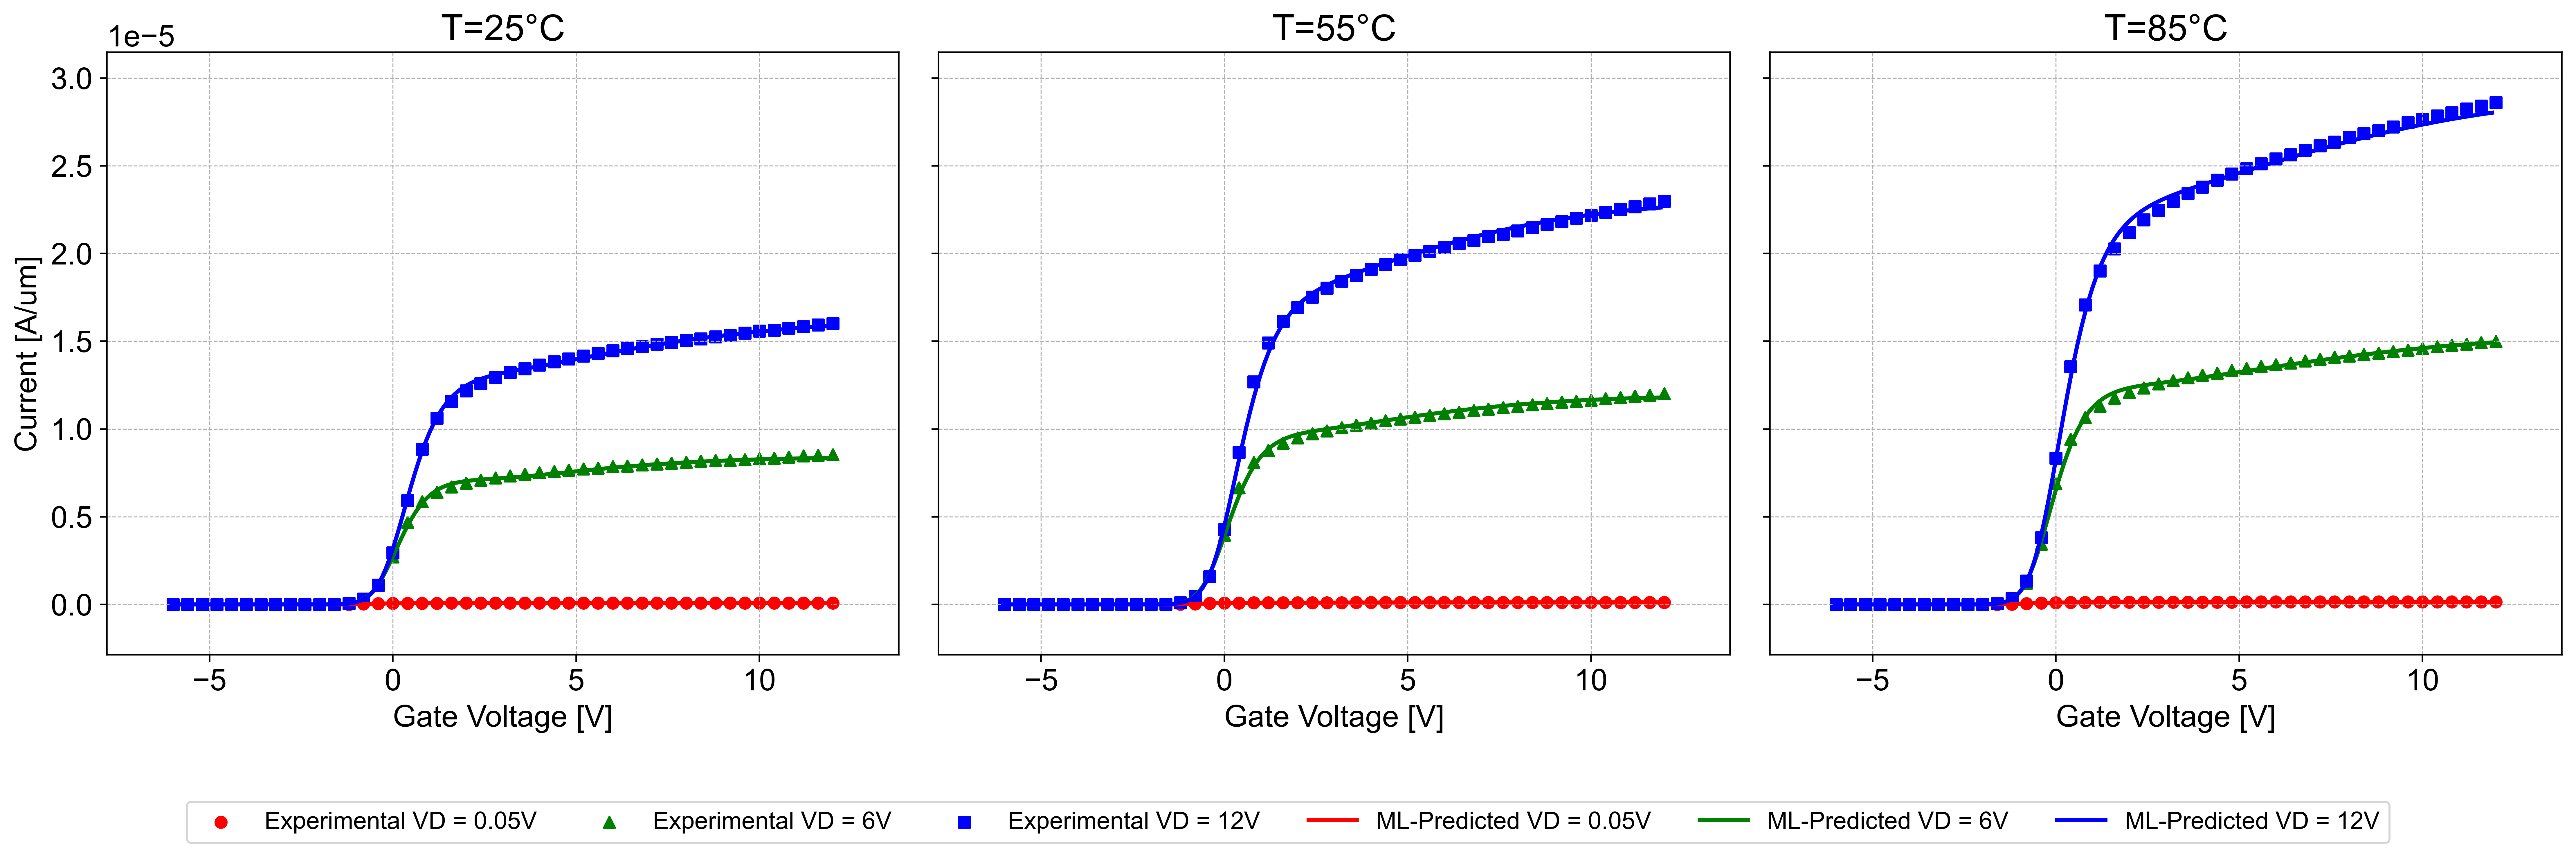

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def Iv_inference(temp_inference):
    xv_test = list(range(-60, 120, 1))
    xv_test = np.array(xv_test)/10
    Xv= []
    # X =[[((x_test[i]/10)-MinV)*normV for i in list(range(len(x_test)))]]
    for i in list(range(len(xv_test_1))):
        temp=[(xv_test[i]-MinVg)*normVg, ((0.05)-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
        Xv.append(temp)

    Predv_y=[]
    for i in list(range(len(xv_test_1))):
        new_var =  torch.FloatTensor(Xv[i])
        pred_y=model(new_var).data.numpy()
        # Tolist=pred_y.tolist()
        Predv_y.append(pred_y)

    Iv_pred =[np.power(10, i/normIt+MinIt) for i in Predv_y]

    Iv_pred=np.array(Iv_pred)

    Iv_final= []
    for i in list(range(len(Iv_pred))):
        Iv_final.extend(Iv_pred[i])

    #### VD =1.042V ####

    Xv11=[]
    for i in list(range(len(xv_test))):
        temp=[(xv_test[i]-MinVg)*normVg, ((6)-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
        Xv11.append(temp)

    Predv_y11=[]
    for i in list(range(len(xv_test))):
        new_var =  torch.FloatTensor(Xv11[i])
        pred_y11=model(new_var).data.numpy()
        Predv_y11.append(pred_y11)

    Iv_pred11 =[np.power(10, i/normIt+MinIt) for i in Predv_y11]

    Iv_pred11=np.array(Iv_pred11)

    Iv_final11= []
    for i in list(range(len(Iv_pred11))):
        Iv_final11.extend(Iv_pred11[i])

    #### VD =3.4V #### 2.337

    Xv25=[]
    for i in list(range(len(xv_test))):
        temp=[(xv_test[i]-MinVg)*normVg, ((12)-MinVd)*normVd, (temp_inference - MinTemperature)*normTemperature]
        Xv25.append(temp)

    Predv_y25=[]
    for i in list(range(len(xv_test))):
        new_var =  torch.FloatTensor(Xv25[i])
        pred_y25=model(new_var).data.numpy()
        Predv_y25.append(pred_y25)

    Iv_pred25 =[np.power(10, i/normIt+MinIt) for i in Predv_y25]

    Iv_pred25=np.array(Iv_pred25)

    Iv_final25= []
    for i in list(range(len(Iv_pred25))):
        Iv_final25.extend(Iv_pred25[i])

    return Iv_final, Iv_final11, Iv_final25

# Sample data for demonstration, replace with your actual data
Vg_test = list(idvg_temp.iloc[:, 0])

Id0_test_25 = list(idvg_temp.iloc[:, 1])
Id_test_25 = list(idvg_temp.iloc[:, 9])
Id2_test_25 = list(idvg_temp.iloc[:, 13])
xv_test_25 = list(xv_test)
Iv_final_25 = list(Iv_inference(25)[0])
Iv_final11_25 = list(Iv_inference(25)[1])
Iv_final25_25 = list(Iv_inference(25)[2])

Id0_test_55 = list(idvg_temp.iloc[:, 15])
Id_test_55 = list(idvg_temp.iloc[:, 23])
Id2_test_55 = list(idvg_temp.iloc[:, 27])
xv_test_55 = list(xv_test)
Iv_final_55 = list(Iv_inference(55)[0])
Iv_final11_55 = list(Iv_inference(55)[1])
Iv_final25_55 = list(Iv_inference(55)[2])

Id0_test_85 = list(idvg_temp.iloc[:, 29])
Id_test_85 = list(idvg_temp.iloc[:, 37])
Id2_test_85 = list(idvg_temp.iloc[:, 41])
xv_test_85 = list(xv_test)
Iv_final_85 = list(Iv_inference(85)[0])
Iv_final11_85 = list(Iv_inference(85)[1])
Iv_final25_85 = list(Iv_inference(85)[2])

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
"""
# Plot for 25C
axs[0].scatter(Vg_test, np.log10(Id0_test_25), s=30, c='red', marker='o')
axs[0].scatter(Vg_test, np.log10(Id_test_25), s=30, c='green', marker='^')
axs[0].scatter(Vg_test, np.log10(Id2_test_25), s=30, c='blue', marker='s')
axs[0].plot(xv_test_25, np.log10(Iv_final_25), linewidth=2, c='red')
axs[0].plot(xv_test_25, np.log10(Iv_final11_25), linewidth=2, c='green')
axs[0].plot(xv_test_25, np.log10(Iv_final25_25), linewidth=2, c='blue')
axs[0].set_title("T=25°C")
axs[0].set_xlabel("Gate Voltage [V]")
axs[0].set_ylabel("Current [A/um (log)]")
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 55C
axs[1].scatter(Vg_test, np.log10(Id0_test_55), s=30, c='red', marker='o', label="Experimental VD = 0.05V")
axs[1].scatter(Vg_test, np.log10(Id_test_55), s=30, c='green', marker='^', label="Experimental VD = 6V")
axs[1].scatter(Vg_test, np.log10(Id2_test_55), s=30, c='blue', marker='s', label="Experimental VD = 12V")
axs[1].plot(xv_test_55, np.log10(Iv_final_55), linewidth=2, c='red', label="ML-Predicted VD = 0.05V")
axs[1].plot(xv_test_55, np.log10(Iv_final11_55), linewidth=2, c='green', label="ML-Predicted VD = 6V")
axs[1].plot(xv_test_55, np.log10(Iv_final25_55), linewidth=2, c='blue', label="ML-Predicted VD = 12V")
axs[1].set_title("T=55°C")
axs[1].set_xlabel("Gate Voltage [V]")
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 85C
axs[2].scatter(Vg_test, np.log10(Id0_test_85), s=30, c='red', marker='o')
axs[2].scatter(Vg_test, np.log10(Id_test_85), s=30, c='green', marker='^')
axs[2].scatter(Vg_test, np.log10(Id2_test_85), s=30, c='blue', marker='s')
axs[2].plot(xv_test_85, np.log10(Iv_final_85), linewidth=2, c='red')
axs[2].plot(xv_test_85, np.log10(Iv_final11_85), linewidth=2, c='green')
axs[2].plot(xv_test_85, np.log10(Iv_final25_85), linewidth=2, c='blue')
axs[2].set_title("T=85°C")
axs[2].set_xlabel("Gate Voltage [V]")
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
"""

# Sampling rate of 1/3
sampling_rate = 4

# Plot for 25°C
axs[0].scatter(Vg_test[::sampling_rate], Id0_test_25[::sampling_rate], s=30, c='red', marker='o', label="Experimental VD = 0.05V")
axs[0].scatter(Vg_test[::sampling_rate], Id_test_25[::sampling_rate], s=30, c='green', marker='^', label="Experimental VD = 6V")
axs[0].scatter(Vg_test[::sampling_rate], Id2_test_25[::sampling_rate], s=30, c='blue', marker='s', label="Experimental VD = 12V")
axs[0].plot(xv_test_25, Iv_final_25, linewidth=2, c='red', label="ML-Predicted VD = 0.05V")
axs[0].plot(xv_test_25, Iv_final11_25, linewidth=2, c='green', label="ML-Predicted VD = 6V")
axs[0].plot(xv_test_25, Iv_final25_25, linewidth=2, c='blue', label="ML-Predicted VD = 12V")
axs[0].set_title("T=25°C")
axs[0].set_xlabel("Gate Voltage [V]")
axs[0].set_ylabel("Current [A/um]")
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 55°C
axs[1].scatter(Vg_test[::sampling_rate], Id0_test_55[::sampling_rate], s=30, c='red', marker='o')
axs[1].scatter(Vg_test[::sampling_rate], Id_test_55[::sampling_rate], s=30, c='green', marker='^')
axs[1].scatter(Vg_test[::sampling_rate], Id2_test_55[::sampling_rate], s=30, c='blue', marker='s')
axs[1].plot(xv_test_55, Iv_final_55, linewidth=2, c='red')
axs[1].plot(xv_test_55, Iv_final11_55, linewidth=2, c='green')
axs[1].plot(xv_test_55, Iv_final25_55, linewidth=2, c='blue')
axs[1].set_title("T=55°C")
axs[1].set_xlabel("Gate Voltage [V]")
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot for 85°C
axs[2].scatter(Vg_test[::sampling_rate], Id0_test_85[::sampling_rate], s=30, c='red', marker='o')
axs[2].scatter(Vg_test[::sampling_rate], Id_test_85[::sampling_rate], s=30, c='green', marker='^')
axs[2].scatter(Vg_test[::sampling_rate], Id2_test_85[::sampling_rate], s=30, c='blue', marker='s')
axs[2].plot(xv_test_85, Iv_final_85, linewidth=2, c='red')
axs[2].plot(xv_test_85, Iv_final11_85, linewidth=2, c='green')
axs[2].plot(xv_test_85, Iv_final25_85, linewidth=2, c='blue')
axs[2].set_title("T=85°C")
axs[2].set_xlabel("Gate Voltage [V]")
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Create a single legend for all subplots
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=1, fontsize=20)
handles, labels = [], []
for ax in axs:
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label)
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=12)

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make room for the legend
plt.show()

In [ ]:
answer_test = [i for sublist in ytest1.tolist() for i in sublist]
#print(answer_test)
#print(output1)


# Instantiate the PyTorch model
model.load_state_dict(torch.load('IWO_idvg_state_dict.pt'))

# Extract the weights and biases from the model
weights_1 = model.fc1.weight.detach().numpy()
bias_1 = model.fc1.bias.detach().numpy()
weights_2 = model.fc2.weight.detach().numpy()
bias_2 = model.fc2.bias.detach().numpy()
weights_3 = model.fc3.weight.detach().numpy()
bias_3 = model.fc3.bias.detach().numpy()

verilog_code = ""

# Create the Verilog-A code for the 1st hidden layer
verilog_code += "\n"#, h1_10, h1_11, h1_12, h1_13, h1_14, h1_15, h1_16, h1_17, h1_18, h1_19, h1_20, h1_21, h1_22, h1_23, h1_24
for i in range(n1):
    inputs = ["Vgs", "Vds", "temp"]
    inputs = ["*".join([str(weights_1[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_1[i])])
    verilog_code += "h1_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the 2nd hidden layer
verilog_code += "\n"#, h2_5, h2_6, h2_7, h2_8, h2_9, h2_10, h2_11;\n"
for i in range(n2):
    inputs = ["h1_{}".format(j) for j in range(n1)]
    inputs = ["*".join([str(weights_2[i][j]), inp]) for j, inp in enumerate(inputs)]
    inputs = "+".join(inputs)
    inputs = "+".join([inputs, str(bias_2[i])])
    verilog_code += "h2_{} = tanh({});\n".format(i, inputs)

# Create the Verilog-A code for the output layer
inputs = ["h2_{}".format(i) for i in range(n2)]
inputs = ["*".join([str(weights_3[0][i]), inp]) for i, inp in enumerate(inputs)]
inputs = "+".join(inputs)
inputs = "+".join([inputs, str(bias_3[0])])
verilog_code += "y = {};\n".format(inputs)

verilog_code = """
module IWO_verilogA (d, g, s);
inout d, g, s;
electrical d, g, s;

//****** Parameters L and W ********
parameter real W = 0.1;
parameter real Temperature = 25;
parameter MinVg = {} ;
parameter normVg = {} ;
parameter MinVd = {} ;
parameter normVd = {} ;
parameter MinTemperature = {} ;
parameter normTemperature = {} ;
parameter MinI = {} ;
parameter normI ={};
real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
real Vgsraw, Vgdraw, dir;

analog begin
	Vg = V(g);
	Vs = V(s);
	Vd = V(d);
    Vgsraw = Vg-Vs ;
    Vgdraw = Vg-Vd ;
if (Vgsraw>=Vgdraw) begin
	Vgs = ((Vg-Vs) - MinVg) * normVg ;
    dir = 1 ;
end
else begin
	Vgs = ((Vg-Vd) - MinVg) * normVg ;
    dir = -1 ;
end
	Vds = (abs(Vd-Vs) - MinVd) * normVd ;
    Temperature = (Temperature - MinTemperature) * normTemperature ;


{}

Id = pow(10, (y/normI + MinI))*W;
I(g, d) <+ Cgsd*ddt(Vg-Vd) ;
I(g, s) <+ Cgsd*ddt(Vg-Vs) ;

if (Vd >= Vs) begin
	I(d, s) <+ dir*Id;
end

else begin
	I(d, s) <+ dir*Id;
end

end
endmodule

""".format(MinVg, normVg, MinVd, normVd, MinTemperature, normTemperature, MinIt, normIt, verilog_code)

print(verilog_code)

with open("iwo_test.va", "w") as f:
    f.write(verilog_code)


module IWO_verilogA (d, g, s);
inout d, g, s;
electrical d, g, s;

//****** Parameters L and W ********
parameter real W = 0.1;
parameter real Temperature = 25;
parameter MinVg = -6.0 ;
parameter normVg = 0.05555555555555555 ;
parameter MinVd = 0.05 ;
parameter normVd = 0.08368200836820085 ;
parameter MinTemperature = 25 ;
parameter normTemperature = 0.016666666666666666 ;
parameter MinI = -10.748600281214967 ;
parameter normI =0.15112898661371651;
real Vg, Vd, Vs, Vgs, Vds, Lg, Id, Cgg, Cgsd, Vgd;
real Vgsraw, Vgdraw, dir;

analog begin
	Vg = V(g);
	Vs = V(s);
	Vd = V(d);
    Vgsraw = Vg-Vs ;
    Vgdraw = Vg-Vd ;
if (Vgsraw>=Vgdraw) begin
	Vgs = ((Vg-Vs) - MinVg) * normVg ;
    dir = 1 ;
end
else begin
	Vgs = ((Vg-Vd) - MinVg) * normVg ;
    dir = -1 ;
end
	Vds = (abs(Vd-Vs) - MinVd) * normVd ;
    Temperature = (Temperature - MinTemperature) * normTemperature ;



h1_0 = tanh(-0.28592426*Vgs+-0.06702367*Vds+-0.08783989*temp+0.0067680436);
h1_1 = tanh(-1.6092799*Vgs+-0.12605947*Vds+-